<br>

# <center>Tabular Data Science Course, Bar-Ilan University</center>
## <center>Final Project, Tabular Data Science Course (89-547)</center>
# <center><b>Automated Adaptive Outlier Handling</b></center>


### Submitted to: <b>Itay Elyashiv & Dr. Amit Somech</b>

#### Submitted by: Yoav Yoscovich

<br><br>

# <b>1. Project Rationale & Overview</b>:
Outliers may significantly degrade the performance of a model, leading to inaccurate predictions; Throughout the years, many methods have been suggested to address this issue, but the choice of method was discretionary and dependent on the dataset and therefore leaves room for improvement. In this project, I offer an automated adaptive outlier handling method, in order to assist performing an easier data science process and achieving better model performance.
I explored <i><b>combining</b> various techniques</i> learned throughout the course, into <i>new enhanced methods</i>, with less weaknesses, achieving better performance. Overall, I will introduce <b><i>three</i> sub-algorithms</b>, and the <i><b>"Yoscovich Algorithm (Data-driven Predicted Best of Three Algorithm)"</b></i>, which combines the three sub-algorithms, by analyzing the nature of each dataset beforehand and choosing the most appropriate sub-algorithm for handling outliers (rather than a naive brute-force algorithm, running all sub-algorithms and choosing the best-performing one). As part of the experimental evaluation, a new evaluation metric (Performance Improvement Metric- PIM) is presented, combining several evaluation metrics; a significant average PIM improvement (beyond 50\%) is shown relative to baseline approaches of outlier handling, for four different datasets. 


This Jupyter notebook exemplifies the solution presented as part of this project, including the three sub-algorithms, the full adaptive algorithm, as well as performs experimental evaluation to propely test the suggested algorithm and show its effectiveness.<br><br>
<b><u>Important</u>!</b> This notebook accompanies the full article I wrote regarding this project (<b>"Automated Adaptive Outlier Handling"</b>), following is a link to the article:
> **Reference**: [<b>link to the full article (LATEX-generated PDF file)</b>](https://github.com/YoavYoscov/TabularDataScience/blob/main/FinalResearchProject/Automated%20Adaptive%20Outlier%20Handling.pdf).


### Importing Required Libraries:

In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Data Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline

# Machine learning library
# Importing xgboost and the evaluation metrics:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

# Importing the train_test_split function from the sklearn.model_selection module, to split the data into training and testing sets.
from sklearn.model_selection import train_test_split

# Importing the stats module from the scipy library:
from scipy import stats

# Importing skew, kurtosis, boxcox, zscore from the scipy.stats library, all of these will be used as part of the data-driven algorithm:
from scipy.stats import skew, kurtosis, boxcox, zscore



<b>Note</b>: in the final project guidelines, we were instructed to include a 'requirements.txt' file only <b>"if you use any non-ordinary libraries (i.e., that we didn't use in class)"</b>; since the ideas, methods and concepts which are part of my suggested solution are inspired by material learned in class (as will be detailed below), I have not used libraries which were not used in class. Namely, the libraries <i>'pandas'</i>, <i>'numpy'</i>, <i>'seaborn'</i>, <i>'matplotlib'</i> were used during lecture #1 of the course, and <i>'scipy'</i> library was used during lecture #2 of the course (regarding goodness of fit). In addition, the 'xgboost' library was also discussed in class, and was specifically advised to use since the first submission in the course. Therefore, in order not to prolong unnecessarily, I have not included such a file as part of the submission.

-----

# <b>2. Solution Overview - Defining The Algorithms</b>:
In this section, I will present:
<ul>
<li>The full adaptive algorithm.</li>
<li>The 3 sub-algorithms used as part of the adaptive algorithm.</li>
<li>The 2 baseline algorithms.</li>
</ul>


### <b><u>The Final Adaptive Algorithm</u>: The Yoscovich Data-Driven Predicted Best of Three Algorithm</b>:
The full <b>data-driven</b> algorithm analyzes the nature of each specific dataset, and decides accordingly which of the sub-algorithms should be applied in each case. <u>It is important to note that this not a naive brute-force algorithm</u>, simply trying running all sub-algorithms and choosing the one which has best-performed, <b>but this data-driven algorithm analyzes the nature of each dataset beforehand, and decides which sub-algorithm is most likely to appropriately handle outliers</b> present in it. It should be noted that <b>a significant part of the algorithm is based on a new metric which I have invented and called <i>"Normalized Variance" (NV)</i></b>. This metric is used in order to characterize the magnitude of high-valued data-points normalized by the mean value, and is calculated as follows:<br>

$$
NV \gets
    \begin{cases}
    \frac{var}{\mu^2} & \text{if } \mu \neq 0 \\
    0 & \text{else}
    \end{cases}
$$


The algorithm chooses which of the three sub-algorithms to should be applied as follows:
<ol>
    <li>
        <b>If the dataset is <i>heavily skewed</i></b> (<b>|S|>3</b> is a standard threshold value for skewness [<i>Shinde Yashowardhan. "What is skewness in data? how to fix
skewed data in python?", Posted on Medium, Aug 27, 2021</i>]): in this case, it is highly important to <i>de-skew</i> the distribution, such that we can rightfully spot which data points are outliers. The de-skewing will transform it to a <u>more normal-like</u> distribution; in order to achieve that, <b>for such a dataset the algorithm will choose to apply the method of Box-Cox + Z-Score</b> (Sub-Algorithm #1, which first performs Box-Cox transformation, then uses the standard method of Z-score outlier removal).
    </li>
    <li>
        <b>If the dataset is <u>not</u> heavily skewed</b>, then there is no need to normalize the distribution, and the question arises whether it is better to <i>remove</i> outliers or <i>cap these outliers to a certain value</i>. <b>For this purpose, I have defined a metric called <i>“Normalized Variance” (NV)</i> which calculates the variance of the dataset and normalizes (divides) the variance by the square of the mean of the dataset</b> (the formula for calculating the <i>NV</i> is detailed above). The use of this metric is as following:
        <ul>
            <li>
                <b>If the normalized variance is < 0.5</b>: this means that there is <i>low variance</i> in the data and therefore <b>the <i>extreme values</i> are not too frequent</b> (since otherwise they would have contributed to a higher normalized variance value); therefore, these extreme values do <u>not</u> carry important information and can be removed as outliers using sub-algorithm #2 (adaptive IQR outlier-removal).
            </li>
            <li>
                <b>If the normalized variance is > 0.5</b>: this means that there is <i>high variance</i> in the data and therefore <b>the <i>extreme values</i> are quite frequent</b> (leading to high normalized variance value); therefore, these extreme values <u>cannot</u> be removed, but need to be represented (<b>they do not seem like errors, but values that should be taken into account</b>) in some way and therefore <i>capping</i> is a more suitable method of handling these extreme values (or outliers), using sub-algorithm #3 (performing outlier-capping based on z-score).
            </li>
        </ul>
    </li>
</ol>
<b><u><i>Pseudo-Code</i> for this algorithm</u>:</b>

In [2]:
def select_outlier_method(df, target_col, toPrint):
    data = df[target_col]

    # Calculating the skewness of the data:
    S = skew(data)

    # Calculating the normalized variance (NV, the new metric I've defined) of the data:
    variance = np.var(data)
    mean = np.mean(data)
    meanSquared = mean**2
    if mean != 0:
        normalizedVariance = variance / meanSquared
    else:
        normalizedVariance = 0

    if toPrint:
        print("Skewness: ", S)
        print("Normalized Variance: ", normalizedVariance)

    # Decision rule #1:
    # If the skewness is greater than 3, this means the data is highly skewed.
    if abs(S) > 3:
        return "Box-Cox + Z-Score"

    # Decision rule #2:
    # If the normalized variance is less than 0.5, this means the data is not too spread out.
    if normalizedVariance < 0.5:
        return "Adaptive IQR Multiplier"
    
    # Decision rule #3:
    # If the normalized variance is >= 0.5, this means the data is spread out (with potential meaningful information).
    else:
        return "Capping with Z-Score"

### <b><u>Sub-Algorithm #1</u>: Box-Cox + Z-Score Algorithm:</b>
The idea for this solution stems from a combination of techniques and concepts which we have learned in different lectures throughout the course. During lecture #5, we have learned about the <b><i>Box-Cox</i> Transformation</b>, which is a statistical technique used to stabilize variance, and <b>approximately make the data closer to a <i>normal distribution</i></b>. One of the useful outlier-detection methods, which was also mentioned in the course, is the <b><i>Z-Score</i> method</b>; this is a statistical technique which is used to identify outliers in a dataset, by measuring <i>the distance between a data point to the mean of the dataset, in terms of standard deviations</i>. In other words, as we have learned in the statistics course, a z-score tells you how many standard deviations a data point is distanced from the mean.

However, as was also mentioned in class, <b>the calculation of the Z-score method, including the mean and standard deviation of the dataset, <u>assumes that the data is normally distributed</u></b>. In other words, while the Z-score method is highly useful when dealing with normal distributed data, <b>when the distribution of the data is different – its effectiveness might severely deteriorate</b>. Therefore, I thought that it is worthwhile checking whether <b>combining these two methods (<i>Box-Cox</i> transformation and <i>Z-Score</i> method for outlier detection)</b> might yield a new, better method, one that is less susceptible to data which is not normally distributed.<br/><br/>
<b><u><i>Pseudo-Code</i> for this sub-algorithm</u>:</b>

In [3]:
def apply_boxcox_transformation(dtf_train, dtf_test, targetVariableName):
    # Shifting to non-negative values: (since Box-Cox can only handle positive values)
    if (dtf_train[targetVariableName] <= 0).any():
        shift = abs(dtf_train[targetVariableName].min()) + 1
        dtf_train[targetVariableName] += shift
        dtf_test[targetVariableName] += shift
    else:
        shift = 0
    
    # Applying Box-Cox transformation, and getting the lambda value:
    dtf_train["targetVariableBoxcox"], lambda_boxcox = boxcox(dtf_train[targetVariableName])
    dtf_test["targetVariableBoxcox"] = boxcox(dtf_test[targetVariableName], lmbda=lambda_boxcox)
    
    # Calculating the z-scores of the target variable:
    z_scores = zscore(dtf_train["targetVariableBoxcox"])
    # Using the Z-Score method to remove outliers (values that are 3 standard deviations away from the mean):
    dtf_train = dtf_train[(z_scores > -3) & (z_scores < 3)]
    
    # Now, inversing the Box-Cox transformation (using the lambda value saved earlier):
    dtf_train[targetVariableName] = ((dtf_train["targetVariableBoxcox"] * lambda_boxcox + 1) ** (1 / lambda_boxcox))
    dtf_test[targetVariableName] = ((dtf_test["targetVariableBoxcox"] * lambda_boxcox + 1) ** (1 / lambda_boxcox))

    # Shifting back:
    dtf_train[targetVariableName] -= shift
    dtf_test[targetVariableName] -= shift
    
    # Note that before returning, I dropped the targetVariableBoxcox column (this was only used for the Box-Cox transformation calculations):
    return dtf_train.drop(columns=["targetVariableBoxcox"]), dtf_test.drop(columns=["targetVariableBoxcox"])


### <b><u>Sub-Algorithm #2</u>: Adaptive IQR Multiplier Algorithm:</b>
<b>A very useful and popular method for outlier detection is using <i>IQR, the interquartile range</i></b>; the IQR is defined as: $IQR=Q_3-Q_1$ In other words, it represents the middle 50% of the data. IQR is often used to find outliers in data – first defined by <i>J. Tukey</i> as observations that fall below $Q_1-1.5IQR$ or above $Q_3+1.5IQR$. <b>The IQR multiplier of 1.5 was introduced by Tukey as a <i>standard heuristic value</i> that is widely used for various cases</b> and indeed very useful to detect outliers (for example, I briefly used it in a project I have submitted last year, in order to filter out outliers from a database for Android application, and it worked well).

However, during lecture #5 in this course, we have learned about <b><i>Moment Skewness</i></b>, and in particular, we learned that the $3^{rd}$ and $4^{th}$ standardized moments are used to measure <b><i>skewness</i></b> and <b><i>kurtosis</i></b>; after we have learned about these $3^{rd}$ and $4^{th}$ moments, I wondered whether calculating them might give insights which can be used to adapt the heuristic IQR multiplier that was suggested by Tukey. In other words, <b>while the standard IQR multiplier is <u>1.5, which works well for symmetrical distributions with standard tails</u></b>, for various other distributions (e.g. highly skewed distribution or fat-tail distribution), 1.5 might not be enough to capture the extremes effectively. Therefore, one of the prominent ideas in this project is <b>formalizing a formula to calculate and adapt the <i>IQR multiplier</i> based on different calculations</b> which can be utilized to develop an <u>appropriate different IQR multiplier, tailored for each specific dataset</u>.

Practically, while the 1.5 multiplier alone is a <i>generic</i> type of formula which does not take into consideration the specific distribution of the dataset; <b>this multiplier can be used as the baseline value but in order to take into account the specific characteristics of the dataset distribution</b>. Following is the optimized formula I have come up with:
<div style="border: 1px solid blue; background-color: #f0f8ff; padding: 5px; display: inline-block;">
    <center><b>The Formula for the Adaptive IQR Multiplier:</b></center>
</div>

$$
\begin{aligned}
    adjustedIqrMultiplier &\gets 1.5+\frac{2}{3}\times (|\textbf{S}|+max(\textbf{K}-3,0)+max(\textbf{meanMedianRatio}-1.5,0) \\
    &\quad +max(\textbf{tailSpread}-3,0) + max(\textbf{outlierRate}-5\%,0))
\end{aligned}
$$


<div style="border: 1px solid blue; background-color: #f0f8ff; padding: 5px; display: inline-block;">
</div>



Let us start with a simple and intuitive explanation of all the factors of these formula. <b>The formula starts with the value of 1.5 taken from Tukey’s article as the default standard value</b>. The simple formula with the 1.5 multiplier alone is a generic type of formula, which does not take into consideration the specific distribution of the dataset. This multiplier can be used as the baseline value but in order to take into account the specific characteristics of the dataset distribution, I have added several other factors that modify this multiplier, making it tailor-made to each specific dataset:
<ol>
    <li>
        <b>Skewness</b> (3rd standardized moment): to make it intuitive, I will consider <b>positive skew</b> as heavier <i>right tail</i> and <b>negative skew</b> as heavier <i>left tail</i>; <b>there is a need to <u>increase</u> the IQR multiplier in order to take into account more data at the tails of the distribution below the removal limit</b>. Therefore, an additional factor of <b>|skewness|</b> is added to the multiplier (absolute value is used since there is a need to increase the IQR multiplier for both right and left sided skews).
    </li>
    <li>
        <b><i>Kurtosis</i></b> (4th standardized moment): an <b><i>excess</i> absolute kurtosis value beyond 3</b> means that there is a <i>heavy tail</i>; therefore, <b>in order to take this factor into account with the IQR multiplier, I have used <i>(Kurtosis-3)</i> as the additional factor</b> (a value of 3 is the kurtosis of a standard normal distribution).
    </li>
    <li>
        <b><i>Tail-spread</i></b>: this is used to compare the range between the 99th percentile and the 1st percentile against the IQR (50% of the data); this parameter measures <i>the extent of the outer tail</i> - <b>if the tail spread is high, it means that there are <i>heavy tails</i> that need to be taken into account and therefore <u>the IQR multiplier should be increased</u></b>. For a <i>normal distribution</i>, the tail spread would be approximately 3 (slightly higher), therefore I subtracted 3 from the tail-spread value, such that for a standard normal distribution it will not change the original 1.5 IQR multiplier.
    </li>
    <li>
        <b><i>Outlier-Rate</i></b>: this represents the <b><i>proportion</i> of outliers relative to the number of data points in the dataset</b>. For a normal distribution, this will be less than 2%, but I took only the value about 5% into account in order to consider only extreme cases.
    </li>
    <li>
        <b><i>Mean-to-Median Ratio</i></b>: this is another metric to calculate whether the data is skewed. I have used it to modify the IQR multiplier only in case of <i>real-skewed data</i> (<b>>1.5, whereas a value of 1.0 is the standard value</b>).
    </li>
</ol>

All of the above factors were added as positive values only (using <i>max</i> function or <i>abs</i> function for skewness) to the standard 1.5 multiplier, scaled with a factor of $\frac{2}{3}$. I have searched for the optimal factor for several datasets and it seemed that the approximate value of $\frac{2}{3}$ was a good, intuitive and practical choice of the factor. Later on in this notebook, after presenting all the sub-algorithms and moving on to to the experimental evaluation, I will show a comparison of the $R^2$ metric for the <i>House Prices dataset</i> (the dataset used in class) for different values of multipliers, where we will see that both <b>the <i>optimum value</i> for the correction factor is around 0.7</b>, <b><i>hence a correction factor of $\frac{2}{3}$ is chosen</i></b>, since this type of optimization was also performed on other datasets, and <b>a correction factor of $\frac{2}{3}$ is <i>consistently</i> close to the optimal one</b>. In addition, to prevent extreme value of IQR, its value is capped between 0.5 and 5.<br/><br/>

<b><u><i>Pseudo-Code</i> for this sub-algorithm</u>:</b>



In [4]:
def compute_iqr_multiplier(data):
    # Calculating basic statistics - skewness and kurtosis of the data:
    skew_value = stats.skew(data)
    kurt_value = stats.kurtosis(data, fisher=True)


    # Calculating the Mean-to-Median Ratio:
    mean_value = np.mean(data)
    median_value = np.median(data)
    if median_value != 0:
        mean_median_ratio = mean_value / median_value
    else:
        mean_median_ratio = 1


    # Calculating IQR=Q3-Q1 (1st and 3rd quartiles):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1

    # Also calculating the 1st and 99th percentiles:
    p1, p99 = np.percentile(data, [1, 99])
    # Using the 1st and 99th percentiles calculated above, we can now calculate the Tail Spread:
    if iqr != 0:
        tail_spread = (p99 - p1) / iqr
    else:
        tail_spread = 0
    
    # Now, I also calculate the Outlier Rate (values that are 1.5*IQR away from the 1st and 3rd quartiles):
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = np.sum((data < lower_bound) | (data > upper_bound))
    outlier_rate = outliers / len(data)
    
    
    # Using the developed IQR Multiplier Formula introduced in the paper:
    iqr_multiplier = 1.5 + (2/3)*(0 
                      + abs(skew_value) 
                      + max(0, kurt_value - 3) 
                      + max(0, tail_spread - 3) 
                      + max(0, outlier_rate - 0.05)  
                      + max(0, mean_median_ratio - 1.5))

    iqr_multiplier = max(0.5, min(iqr_multiplier, 5))  
    return round(iqr_multiplier, 2)

# The following function applies the IQR method with the adaptive multiplier (it calls the function above which calculates the multiplier, and then applies the IQR method accordingly):
def apply_iqr_withAdaptiveMultiplier(dtf_train, dtf_test, targetVariableName):
    iqr_multiplier = compute_iqr_multiplier(dtf_train[targetVariableName])
    
    Q1 = dtf_train[targetVariableName].quantile(0.25)
    Q3 = dtf_train[targetVariableName].quantile(0.75)
    IQR = Q3 - Q1

    # It is important to note the use of 'iqr_multiplier', which is the calculated multiplier (according to the formula explained in the article), rather than using the generic 1.5 multiplier:
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    dtf_train = dtf_train[(dtf_train[targetVariableName] >= lower_bound) & (dtf_train[targetVariableName] <= upper_bound)]
    return dtf_train, dtf_test

### <b><u>Sub-Algorithm #3</u>: Outlier Capping + Z-Score Algorithm:</b>
The $3^{rd}$ sub-algorithm is different from the two previous sub-algorithms since it performs outlier <b><i>Capping</i></b> instead of removal. <b><i>Capping</i></b> replaces <i>extreme values</i> with predefined <i>threshold values</i>, instead of removing them. As outlined by <i>Anushree</i>: <b>"Capping is the process of converting outliers into data which you don’t consider as outliers, by simply deciding a boundary value in the data lying beyond the boundary is taken inside the boundary"</b> (Biswas Anushree. "Handling outliers", 2023. Medium, Jun 17, 2023). Common capping uses  thresholds of the 1% and 99% percentiles, known as <b><i>"Winsorization"</i></b>, a term proposed by <i>Wilfrid Joseph Dixon</i> in 1960 to commemorate <i>Charles P. Winsor</i>, who first suggested the basis for the method (W. J. Dixon. "Simplified estimation from censored normal samples.",
Ann. Math. Statist., 31(4):385–391, 1960). Practically, this method caps any values outside these percentiles to the corresponding value of the percentile. I will not use the <i>regular Winsorization</i> method, as it is quite limited due to use of the same values for outlier detection and value for capping. Alternatively, the following sub-algorithm still uses the 1% and 99% for the capped value but uses the standard <i>Z-score method</i> to detect outliers to be handled.

<b>In general, sometimes outliers are a result of <i>true variability</i> and shouldn't be removed completely</b> (e.g. for a salary database, a top executive salary should not be removed but can be capped in order to reduce its bias). Extreme values may indicate important trends rather than errors, and removing them may sabotage the model and therefore capping is more appropriate.

<b><u><i>Pseudo-Code</i> for this sub-algorithm</u>:</b>

In [5]:
def apply_capping_zscore(dtf_train, dtf_test, targetVariableName):
    # First, calculating the z-scores of the target variable:
    z_scores = zscore(dtf_train[targetVariableName])
    # I create a mask which basically "masks" - tells which values are more than 3 standard deviations away from the mean (these are the outliers):
    mask = (z_scores < -3) | (z_scores > 3)

    # Calculating the 1st and 99th percentiles of the target variable:
    lower_bound = dtf_train[targetVariableName].quantile(0.01)
    upper_bound = dtf_train[targetVariableName].quantile(0.99)

    # This is important - the capping is done for the values that are more than 3 standard deviations away from the mean:
    # So, the outlier detection is done using the Z-Score method, but the capping is done using the 1st and 99th percentiles:
    dtf_train.loc[mask, targetVariableName] = dtf_train.loc[mask, targetVariableName].clip(lower=lower_bound, upper=upper_bound)
    return dtf_train, dtf_test

# <b><u>Baseline Algorithms</u>:</b>

### <b><u>Baseline Algorithm #1</u>: IQR Outlier Removal (with the generic 1.5 multiplier):</b>
This is the first <b>baseline</b> algorithm I will use throuout this work in order to calculate and present various visualizations comparing the effect on the suggested algorithm on model's performance against effect of the baseline algorithm on model's performance; in particular, this serves as a baseline algorithm especially for the $2^{nd}$ sub-algorithm (which further develops the regular IQR method, by calculating a tailor-made adaptive IQR multiplier, based on the characteristics of each dataset).
<br><br>
Regarding the logic of this baseline algorithm: <b>A very useful (baseline) method for outlier detection is using <i>IQR, the interquartile range</i></b>, defined as: $IQR=Q_3-Q_1$ (middle 50% of the data). Finding outliers by IQR was suggested by  <i>J. Tukey</i> (John W. Tukey. "Exploratory Data Analysis", Addison-Wesley
Publishing Company, 1977) as observations that are outside of [$Q_1-1.5IQR$, $Q_3+1.5IQR$]. <b>The IQR multiplier of 1.5 introduced by Tukey as a <i>standard heuristic value</i> is widely used for various cases</b> and indeed very useful to detect outliers. 
<br><u>Pseudo-Code for this baseline algorithm</u>:


In [6]:
def apply_iqr_outlier_removal(dtf_train, dtf_test, targetVariableName):
    # Calculating the 1st and 3rd quartiles, and the IQR accordingly:
    Q1 = dtf_train[targetVariableName].quantile(0.25)
    Q3 = dtf_train[targetVariableName].quantile(0.75)
    IQR = Q3 - Q1

    # Based on the calculated IQR, calculating the lower and upper bounds (using the generic 1.5 multiplier - the standard method):
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Removing the outliers (values that are more than 1.5*IQR away from the 1st and 3rd quartiles):
    dtf_train = dtf_train[(dtf_train[targetVariableName] >= lower_bound) & (dtf_train[targetVariableName] <= upper_bound)]
    return dtf_train, dtf_test

### <b><u>Baseline Algorithm #2</u>: Z-Score Outlier Removal:</b>
This is the second <b>baseline</b> algorithm I will use throuout this work in order to calculate and present various visualizations comparing the effect on the suggested algorithm on model's performance against effect of the baseline algorithm on model's performance; in particular, this serves as a baseline algorithm especially for the $1^{st}$ and $3^{rd}$ sub-algorithms (which further develop the regular Z-Score method, as explained above: sub-algorithm #1 first performs a Box-Cox transformation before applying the z-score method, and sub-algorithm #3 still uses the z-score method for identifying outliers, but caps their values according to the 1% or 99% percentiles).
<br><br>
Regarding the logic of this baseline algorithm: <b>a useful (baseline) method for outlier detection is the <i>Z-Score</i> method</b> - a statistical technique used to identify outliers in a dataset, by measuring <i>distance of data points to the mean of the dataset, in terms of standard deviations</i>. In other words, z-score tells you how many standard deviations a data point is distanced from the mean. However, as mentioned in class, <b>the calculation of the Z-score, <u>assumes that the data is normally distributed</u></b> and therefore the effectiveness of the Z-score method for a non-normal distributed data may severely deteriorate (and the idea for sub-algorithm #1 completely stems from trying to address this weakness). 
<br> <u>Pseudo-Code for this baseline algorithm</u>:


In [7]:
def apply_zscore_outlier_removal(dtf_train, dtf_test, targetVariableName):
    # I calculate the z-scores of the target variable, and then remove the outliers (values that are more than 3 standard deviations away from the mean):
    dtf_train = dtf_train[(zscore(dtf_train[targetVariableName]) > -3) & (zscore(dtf_train[targetVariableName]) < 3)]
    return dtf_train, dtf_test

### <b><u>The Original Pipeline</u>: NO Outlier Handling</b>
This method performs no outlier-handling, and will be used to compare other methods to the original pipeline, to evaluate their effectiveness.

In [8]:
def apply_no_transformation(dtf_train, dtf_test, targetVariableName):
    # This function is defined so when looping through the various outlier removal methods, I can apply the "No Transformation" method (which does nothing) - comparing to the original pipeline:
    return dtf_train, dtf_test

The following function gets a specific outlier-handling method to perform, then applies it, trains the model, and returns the evaluation metrics accordingly.<br>
<b>This will be used to evaluate the effect of each outlier-handling method on the model's performance</b>:

In [9]:
def train_and_evaluate(dtf_train, dtf_test, method_name, targetVariableName):
    # Splitting the data into X and y:
    X_train = dtf_train.drop([targetVariableName], axis=1)
    X_test = dtf_test.drop([targetVariableName], axis=1)
    y_train = dtf_train[targetVariableName]
    y_test = dtf_test[targetVariableName]
    
    # Training the model (XGBoost):
    model = XGBRegressor()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # The four evaluation metrics used:
    metrics = {
        "Method": method_name,
        "R^2 Score": r2_score(y_test, predictions),
        "MAPE": mean_absolute_percentage_error(y_test, predictions),
        "MAE": mean_absolute_error(y_test, predictions),
        "RMSE": np.sqrt(mean_squared_error(y_test, predictions))
    }
    
    return metrics

# Also defining the 6 different variations of the outlier removal methods we are going to perform for each dataset, this will be the basis for the experimental evaluation
# (thus enabling the comparison of the adaptive algorithm (with the sub-algorithm it has selcted), and veify that it indeed outperforms all other algorithms -
# both the original pipeline, the two baseline algorithms, and the other two sub-algorithms):
methods = {
    "Original - no outlier handling": apply_no_transformation,
    "Naive IQR": apply_iqr_outlier_removal,
    "Naive Z-Score": apply_zscore_outlier_removal,
    "Box-Cox + Z-Score": apply_boxcox_transformation,
    "Adaptive IQR Multiplier": apply_iqr_withAdaptiveMultiplier,
    "Capping with Z-Score": apply_capping_zscore
}


## <b><u>Functions generating the main plots shown throughout this notebook</u>:</b>

<b>The following function will be called throughout this notebook several times (for each of the 4 datasets), in order to <u>plot an evaluation metrics comparison</u> between the performance of the model according to the <i>original pipeline</i>, and the performance of the model after applying each of the <i>3 sub-algorithms</i> and each of the <i>2 baseline algorithms</i></b>. The full algorithm will be evaluated by the following evaluation metrics:
<ol>
    <li><b><i>R^2 (Coefficient of Determination)</i></b>: evaluates how well the model explains the variance of the target variable- an $R^2$ score close to 1 shows good fit.</li>
    <li><b><i>MAE (Mean Absolute Error)</i></b>: measures the average absolute difference (predictions-actual values), expressed by the variable units (scale-dependent). </li>
    <li><b><i>MAPE (Mean Absolute Percentage Error)</i></b>: similar to MAPE but the average is over percentage differences- it is <u>scale-independent</u>, useful when dealing with small value predictions.</li>
    <li><b><i>RMSE (Root Mean Squared Error)</i></b>: measures the average quadratic difference (predictions-actual values)- penalizing large errors more, and is more sensitive to outliers. Comparison of RMSE to MAE before and after outlier handling shows if these outliers were significant or not (quadratic vs. linear relationship).</li>
    <li><b><i>Percentage Improvement Metric</i></b>: a combined evaluation metric which I developed, which will be introduced later on in this notebook.</li>
</ol>

This plot will help indicate whether the sub-algorithm chosen to be performed (according to the logic of the <i>main, adaptive algorithm</i>) is indeed the best one to apply for that dataset; <b>in other words, if we see that the perfomance of the model after peforming the sub-algorithm which our algorithm chose is the best perfomance compared to performing the other 2 sub-algorithms <u>AND</u> the two baseline algorithms <u>AND</u> the original pipeline - this indicates that our algorithm is effective and helps achieving better model performance (at least for that dataset)</b>. To thoroughly and properly test the algorithm, I will call this function for each of the 4 dataset which will be used in this notebook.

In [10]:
def plot_evaluation_metrics_comparison(evaluation_metrics, original_values, *steps_values, step_labels=None, colors=None):
    # In each "step", different algorithm out of the 6 (3 sub-algorithms, 2 baseline algorithm and 1 original pipeline) is applied, and the change in the evaluation metrics is calculated (in %).
    num_steps = len(steps_values)
    fig_width = 10 + (num_steps - 1) * 1.5
    fig, ax = plt.subplots(figsize=(fig_width, 8))
    barWidth = 0.8 / (num_steps + 1)
    r1 = np.arange(len(evaluation_metrics))

    # I also add a line representing the original pipeline (0% change) to make the comparison clearer:
    ax.axhline(0, color='black', linewidth=2, linestyle='--', label='Original Pipeline (0% change)')

    # Calculating the change in % for each algorithm:
    percentage_changes = []
    for step_values in steps_values:
        percentage_change = [(after - before) / before * 100 for before, after in zip(original_values, step_values)]
        percentage_changes.append(percentage_change)

    # Plotting the bars for each algorithm:
    for i, percentage_change in enumerate(percentage_changes):
        label = step_labels[i] if step_labels else f'Step {i+1}'
        color = colors[i] if colors else None
        ax.bar(r1 + i * barWidth, percentage_change, width=barWidth, edgecolor='grey', label=label, color=color)

    ax.set_xticks(r1 + barWidth * (num_steps - 1) / 2)
    ax.set_xticklabels(evaluation_metrics)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    ax.set_xlabel('Evaluation Metric')
    ax.set_ylabel('Percentage Change (%)')
    ax.set_title('Evaluation metrics comparison (each method vs. original pipeline)')
    ax.legend()

    # Adding text on each bar (the % change for it)
    for i, percentage_change in enumerate(percentage_changes):
        for j, v in enumerate(percentage_change):
            if v < -99:
                text = f'{v:.3f}%'
            else:
                text = f'{v:.1f}%'
            if v < 0:
                ax.text(j + i * barWidth, v, text, ha='center', va='top')
            else:
                ax.text(j + i * barWidth, v, text, ha='center', va='bottom')
    
    # The following line was used in order to save the plot as a PDF file (to be added as a figure in the article):
    # plt.savefig('fullComparisonCarPrices.pdf', bbox_inches='tight')
    plt.show()


<b>The following function will be called throughout this notebook several times (for each of the 4 datasets), in order to <u>plot a <u>summarized</u> evaluation metrics comparison</u> between the following</b>:
<ol>
    <li>The performance of the model <b>according to the <i>original pipeline</i></b>.</li>
    <li>The performance of the model after <b>applying the <i>most relevant baseline algorithm</i></b> (the most relevant baseline algorithm is determined according to the sub-algorithm which our adaptive full algorithm chose to apply; if it chose to perform sub-algorithm #1 (Box-Cox + Z-Score) or sub-algorithm #3 (Outlier Capping + Z-Score), the most relevant baseline algorithm will be baseline algorithm #2 (Naive Z-Score), and if it chose to perform sub-algorithm #2 (Adaptive IQR Multiplier), the most relevant baseline algorithm will be baseline algorithm #1 (Naive IQR).</li>
    <li>The performance of the model after <b>applying our <i>adaptive algorithm</i></b> (which chooses to perform a sub-algorithm out of the three).</li>
</ol>
This will also indicate whether the adaptive algorithm indeed outperforms both the most relevant baseline algorithm and the original pipeline performance; <b>in other words, if we see that the perfomance of the model after applying our adaptive algorithm outperforms <u>BOTH</u> the most relevant baseline algorithm and the original pipeline - this indicates that our algorithm is effective and helps achieving better model performance (at least for that dataset)</b>. To thoroughly and properly test the algorithm, I will call this function for each of the 4 dataset which will be used in this notebook.

In [ ]:
def plot_comparison(xgb_r2_original, xgb_mape_original, xgb_mae_original, xgb_rmse_original,
                    xgb_r2_baseline, xgb_mape_baseline, xgb_mae_baseline, xgb_rmse_baseline,
                    xgb_r2_best, xgb_mape_best, xgb_mae_best, xgb_rmse_best):
    # Plotting a graph comparing each of the 4 evaluation metrics for the original pipeline and the improved pipeline:
    plt.figure(figsize=(10, 10))

    # Plotting the R^2 Score
    plt.subplot(2, 2, 1)
    bars = plt.bar(['Original Pipeline', 'Most Relevant Baseline', 'The Algorithm'], 
                   [xgb_r2_original, xgb_r2_baseline, xgb_r2_best], 
                   color=['lightblue', 'lightcoral', 'lightgreen'])
    plt.axhline(y=min(xgb_r2_original, xgb_r2_baseline, xgb_r2_best), color='red', linestyle='--')
    plt.title('R^2 Score Comparison')
    plt.ylabel('R^2 Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=25, ha='right') 
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    # Plotting the Mean Absolute Percentage Error (MAPE)
    plt.subplot(2, 2, 2)
    bars = plt.bar(['Original Pipeline', 'Most Relevant Baseline', 'The Algorithm'], 
                   [xgb_mape_original, xgb_mape_baseline, xgb_mape_best], 
                   color=['lightblue', 'lightcoral', 'lightgreen'])
    plt.axhline(y=min(xgb_mape_original, xgb_mape_baseline, xgb_mape_best), color='red', linestyle='--')
    plt.title('Mean Absolute Percentage Error (MAPE) Comparison')
    plt.ylabel('MAPE')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=25, ha='right')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    # Plotting the Mean Absolute Error (MAE)
    plt.subplot(2, 2, 3)
    bars = plt.bar(['Original Pipeline', 'Most Relevant Baseline', 'The Algorithm'], 
                   [xgb_mae_original, xgb_mae_baseline, xgb_mae_best], 
                   color=['lightblue', 'lightcoral', 'lightgreen'])
    plt.axhline(y=min(xgb_mae_original, xgb_mae_baseline, xgb_mae_best), color='red', linestyle='--')
    plt.title('Mean Absolute Error (MAE) Comparison')
    plt.ylabel('MAE')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=25, ha='right')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, int(round(yval, 0)), ha='center', va='bottom')
        

    # Plotting the Root Mean Squared Error (RMSE)
    plt.subplot(2, 2, 4)
    bars = plt.bar(['Original Pipeline', 'Most Relevant Baseline', 'The Algorithm'], 
                   [xgb_rmse_original, xgb_rmse_baseline, xgb_rmse_best],
                    color=['lightblue', 'lightcoral', 'lightgreen'])
    plt.axhline(y=min(xgb_rmse_original, xgb_rmse_baseline, xgb_rmse_best), color='red', linestyle='--')
    plt.title('Root Mean Squared Error (RMSE) Comparison')
    plt.ylabel('RMSE')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=25, ha='right')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, int(round(yval, 0)), ha='center', va='bottom')

    plt.tight_layout()
    # The following line was used in order to save the plot as a PDF file (to be added as a figure in the article):
    # plt.savefig('comparisonFourMetricsHouses.pdf', bbox_inches='tight')
    plt.show()

## <b><u>Introducing a new evaluation metric I have developed - The Percentage Improvement Metric (<i>PIM</i>)</u>:</b>
The analysis so far has calculated four analysis metrics ($R^2$, MAPE, MAE and RMSE). To simplify, <b>I suggest a <u><i>combined</i> metric/score I developed</u>, which averages the percentage improvement of these four parameters relative to the original baseline (or pipeline)</b>. 
Percentage improvement enables combining metrics of different value ranges/trends ($R^2$ has opposite trend than the other three). The suggested <b><i>Percentage Improvement Metric</i> (PIM)</b>:

\begin{align*}
    \textbf{PIM [\%]} & \gets \frac{100}{4} \times [(\frac{R^2_{alg}}{R^2_{org}} -1) +  (1-\frac{MAPE_{alg}}{MAPE_{org}}) \\
    &\quad +  (1-\frac{MAE_{alg}}{MAE_{org}}) +  (1-\frac{RMSE_{alg}}{RMSE_{org}})]
\end{align*}

The following function calcualtes the PIM score for both the adaptive algorithm and the most relevant baseline algorithm, according to the base evaluation metrics scores of the original pipeline, after applying the algorithm, and after applying the most relevant baseline algorithm. <b>This function will be called several times throught the code, in order to show that the PIM score after applying the adaptive algorithm is better than the most relevant baseline algorithm (and of course better than the 0% score - which is the score according to the original pipeline)</b>.

In [12]:
def calculatePIM(xgb_r2_originalPipeline, xgb_mape_originalPipeline, xgb_mae_originalPipeline, xgb_rmse_originalPipeline,
                                     xgb_r2_bestMethod, xgb_mape_bestMethod, xgb_mae_bestMethod, xgb_rmse_bestMethod,
                                     xgb_r2_mostRelevantBaseline, xgb_mape_mostRelevantBaseline, xgb_mae_mostRelevantBaseline, xgb_rmse_mostRelevantBaseline):
    # Calculating the Percentage Improvement Metric (PIM), in %, for the algorithm vs. the original pipeline:
    improvement_algorithm = [
        -25 * (1 - (xgb_r2_bestMethod / xgb_r2_originalPipeline)),
        25 * (1 - (xgb_mape_bestMethod / xgb_mape_originalPipeline)),
        25 * (1 - (xgb_mae_bestMethod / xgb_mae_originalPipeline)),
        25 * (1 - (xgb_rmse_bestMethod / xgb_rmse_originalPipeline))
    ]
    algorithm_PIM_score = sum(improvement_algorithm)

    # Calculating the Percentage Improvement Metric (PIM), in %, for the most relevant baseline vs. the original pipeline:
    improvement_most_relevant_baseline = [
        -25 * (1 - (xgb_r2_mostRelevantBaseline / xgb_r2_originalPipeline)),
        25 * (1 - (xgb_mape_mostRelevantBaseline / xgb_mape_originalPipeline)),
        25 * (1 - (xgb_mae_mostRelevantBaseline / xgb_mae_originalPipeline)),
        25 * (1 - (xgb_rmse_mostRelevantBaseline / xgb_rmse_originalPipeline))
    ]
    most_relevant_baseline_PIM_score = sum(improvement_most_relevant_baseline)
    
    return algorithm_PIM_score, most_relevant_baseline_PIM_score

<b>The following function will be used to show a plot comparing the PIM score of our adaptive algorithm vs. the PIM score of the most relevant baseline:</b>

In [13]:
def plot_pim_comparison(baseline_score, algorithm_score, nameOfBaseline, nameOfAlgorithm):
    # Plotting a graph comparing the Percentage Improvement Metric (PIM), in %, for the algorithm and the most relevant baseline:
    plt.figure(figsize=(4.5, 6))

    # Defining labels for the plot (we run this function each time for a different algorithm, each one has a different relevant baseline algorithm):
    labels = ['Most Relevant Baseline\n(' + nameOfBaseline + ')', 'The Algorithm\n(' + nameOfAlgorithm + ')']
    values = [baseline_score, algorithm_score]

    # Plotting the bars:
    bars = plt.bar(labels, values, color=['lightblue', 'lightgreen'])

    # Adding a horizontal line at y=0 for reference
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Percentage Improvement Metric (PIM) Comparison')
    plt.ylabel('PIM (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjusting y-axis limits for better readability
    plt.ylim(min(values) - 10, max(values) + 10)

    # Adding text on each bar (the % change for it):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{round(yval, 2)}%', ha='center', va='bottom' if yval >= 0 else 'top')

    # Showing the plot (I also showed a legend - explanation that the dotted line represents the original pipeline)
    plt.tight_layout()
    plt.legend(['0% PIM - Original Pipeline'])
    plt.show()

The following function is similar to the <i>'plot_pim_comparison'</i> function above, it also presents a comparison between the PIM score of our adaptive algorithm vs. the PIM score of the most relevant baseline, but <b>this function shows 4 PIM comparison plots, each one for each of the 4 datasets which is used throughout this notebook</b>.

In [14]:
def plot_pim_comparison_forAllFourDatasets(baseline_score1, algorithm_score1, datasetName1, baselineName1, algorithmName1, baseline_score2, algorithm_score2, datasetName2, baselineName2, algorithmName2, baseline_score3, algorithm_score3, datasetName3, baselineName3, algorithmName3, baseline_score4, algorithm_score4, datasetName4, baselineName4, algorithmName4):
    # Defining the labels and values for each dataset, based on the parameters passed to the function:
    datasets = [
        (baseline_score1, algorithm_score1, datasetName1),
        (baseline_score2, algorithm_score2, datasetName2),
        (baseline_score3, algorithm_score3, datasetName3),
        (baseline_score4, algorithm_score4, datasetName4)
    ]

    # Creating a figure with 4 subplots side by side (one for each dataset):
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

    for i, (baseline_score, algorithm_score, dataset_name) in enumerate(datasets):
        ax = axes[i]
        labels = ['Relevant Baseline\n(' + eval(f'baselineName{i+1}') + ')', 'The Algorithm\n(' + eval(f'algorithmName{i+1}') + ')']
        values = [baseline_score, algorithm_score]

        # Plotting the bars
        bars = ax.bar(labels, values, color=['lightblue', 'lightgreen'])
        # Adding a horizontal line at y=0 for reference (the original pipeline)
        ax.axhline(y=0, color='red', linestyle='--')
        ax.set_xticklabels(labels, ha='center')
        ax.set_title(f'PIM Comparison\n{dataset_name}')
        ax.set_ylabel('PIM (%)')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjusting y-axis limits for better readability:
        ax.set_ylim(-58, max(values) + 10)

        # Adding text on each bar (the % change for it):
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{round(yval, 2)}%', ha='center', va='bottom' if yval >= 0 else 'top')

        if i == 0:
            # Adding legend to the first subplot (there is no need to add it to all subplots, it's the same...):
            ax.legend(['0% PIM - Original Pipeline'])

    # Showing the plot:
    plt.tight_layout()
    # The following line was used in order to save the plot as a PDF file (to be added as a figure in the article):
    # plt.savefig('fourPIMPlots.pdf', bbox_inches='tight')
    plt.show()


----

# <b>4. Experimental Evaluation:</b>

After formalizing the algorithms, in this section I will present an experimental evaluation which is performed to verify their validity and performance relative to the baseline, showing a considerable improvement.
The following <b><i>four</i></b> datasets will be used:
<ol>
    <li><b><i>House Prices dataset</i></b>- used throughout the course, having 1460 records; <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data">link to the dataset on <i>Kaggle</i></a>.</li>
    <li><b><i>The largest diamond dataset currently on Kaggle</i></b>- used for two previous course assignments, having 219,703 records; <a href="https://www.kaggle.com/datasets/hrokrin/the-largest-diamond-dataset-currely-on-kaggle/data">link to the dataset on <i>Kaggle</i></a>.</li>
    <li><b><i>Insurance Prices</i></b>: 1338 records; <a href="https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance?resource=download">link to the dataset on <i>Kaggle</i></a>.</li>
    <li><b><i>Car Prices</i></b>: having 8128 records; <a href="https://www.kaggle.com/datasets/sukhmandeepsinghbrar/car-price-prediction-dataset">link to the dataset on <i>Kaggle</i></a>.</li>
</ol>

# <b>1st Dataset: House Prices dataset</b>
This is the dataset which has been used in class throughout the course, having 1460 records.</br>
> **Reference**: [<b>link to the dataset on Kaggle</b>](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

<b>Loading the dataset and getting the model's performance according to the original pipeline (NO outlier handling):</b>

In [15]:
dtf = pd.read_csv("./data/data_housesCLASS.csv",index_col=0)
targetVariableName = 'SalePrice'

print("1st dataset (Houses) - Original Pipeline Performance:")
# Printing the number of rows in the dataset:
print("Number of rows in the dataset: ", len(dtf))
dtf = dtf.select_dtypes(include=[np.number])
dtf_train, dtf_test = train_test_split(dtf, test_size=0.2, random_state=42)

# Separating X from y (X are the features, y is the target variable):
X_train = dtf_train.drop(targetVariableName,axis=1)
X_test = dtf_test.drop(targetVariableName,axis=1)

y_train = dtf_train[targetVariableName]
y_test = dtf_test[targetVariableName]

# Initializing the XGBoost regressor model:
xgb_model = XGBRegressor()
# Training the model on the training data (fitted to the training data):
xgb_model.fit(X_train, y_train)

# Now, we can make predictions on the test data:
prediction = xgb_model.predict(X_test)

# Evaluating the model using the evaluation metrics we have imported above:
xgb_r2 = r2_score(y_test, prediction)
xgb_mape = mean_absolute_percentage_error(y_test, prediction)
xgb_mae = mean_absolute_error(y_test, prediction)
xgb_rmse = np.sqrt(mean_squared_error(y_test, prediction))

# Printing the evaluation metrics:
print(f"R^2 Score: {xgb_r2:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {xgb_mape:.3f}")
print(f"Mean Absolute Error (MAE): {xgb_mae:.0f}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse:.0f}")


1st dataset (Houses) - Original Pipeline Performance:
Number of rows in the dataset:  1460
R^2 Score: 0.869
Mean Absolute Percentage Error (MAPE): 0.115
Mean Absolute Error (MAE): 19372
Root Mean Squared Error (RMSE): 31687


### <b>Which sub-algorithm would our algorithm choose to apply for this dataset, and why?</b>

In [16]:
# Using our adaptive data-driven algorithm (implemented above) for selecting the most relevant sub-algorithm for the dataset:
print(select_outlier_method(dtf_train, targetVariableName, True))

Skewness:  1.7408891554667465
Normalized Variance:  0.1811774968704533
Adaptive IQR Multiplier


Since the calculated <i>skewness</i> of this dataset is 1.74 (<3), and its <i>Normalized Variance</i> is 0.18 ($<\frac{1}{2}$), according to the adaptive algorithm, sub-algorithm #2 (<b><i>Adaptive IQR Multiplier</i></b>) will be applied and therefore its relevant baseline is the <i>naive IQR</i> algorithm (generic 1.5 multiplier).
<br>
<b>First, to present the absolute numbers I will present a table</b> with the performance of the model after according to the original pipeline OR after applying each of the 2 baseline algorithms OR after applying each of the 3 sub-algorithms introduced in this project; this table is presented above, <b>and afterwards I will show plots presenting that information clearly, but in a graphic display</b>.

In [17]:
# I create a list storing the results of each evaluation metric (R^2, MAPE, MAE, RMSE) for each of the 6 outlier removal methods:
results = []
# Iterating through all the six algorithms (the original pipeline, the two baseline algorithms, and the three sub-algorithms):
for method_name, method in methods.items():
    modified_train, modified_test = method(dtf_train.copy(), dtf_test.copy(), targetVariableName)
    metrics = train_and_evaluate(modified_train, modified_test, method_name, targetVariableName)
    # Saving the results for the current algorithm:
    results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df)

                           Method  R^2 Score      MAPE           MAE  \
0  Original - no outlier handling   0.869101  0.115332  19372.175714   
1                       Naive IQR   0.713476  0.117413  21634.095877   
2                   Naive Z-Score   0.775222  0.119905  21137.077831   
3               Box-Cox + Z-Score   0.840893  0.110941  19202.686778   
4         Adaptive IQR Multiplier   0.903189  0.106062  17220.163380   
5            Capping with Z-Score   0.843918  0.114232  19573.041698   

           RMSE  
0  31686.522696  
1  46879.991298  
2  41522.526749  
3  34934.254192  
4  27250.139316  
5  34600.592219  


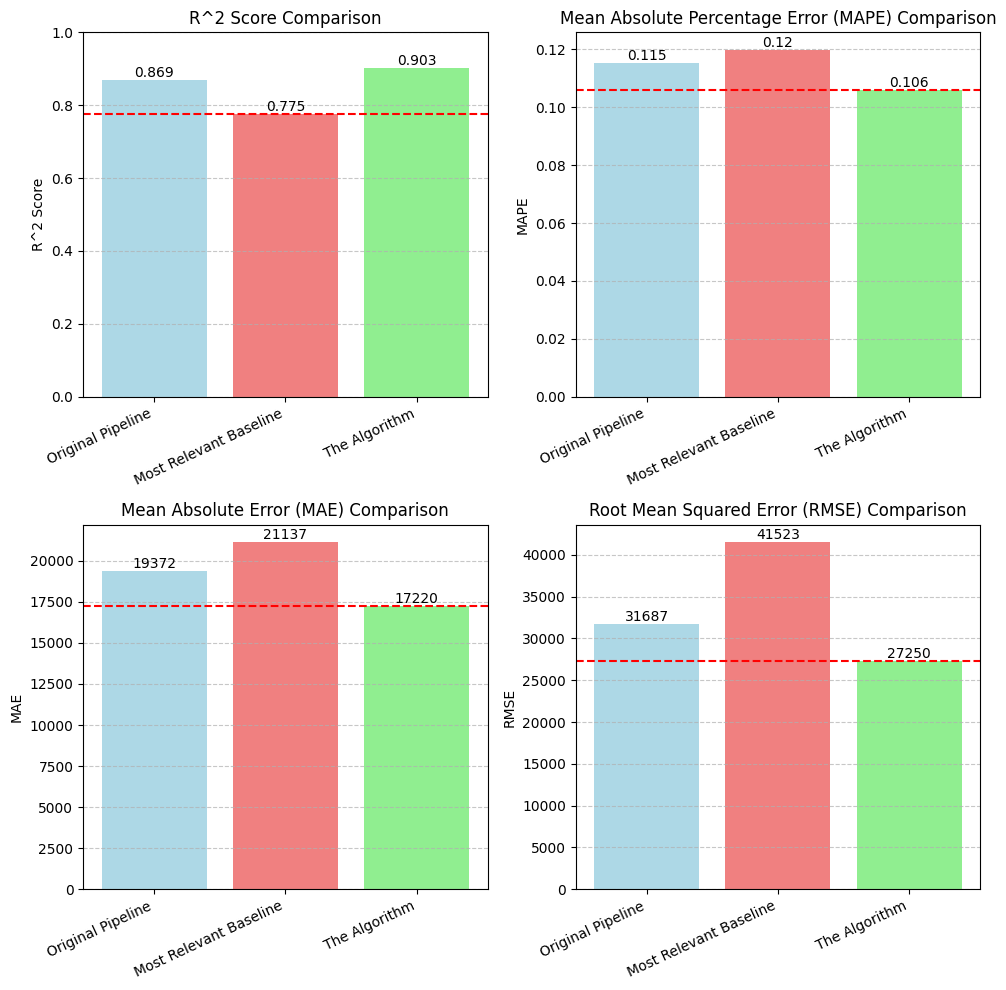

In [18]:
# Extracting the required values from the results_df:
xgb_r2_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "R^2 Score"].values[0]
xgb_mape_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "MAPE"].values[0]
xgb_mae_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "MAE"].values[0]
xgb_rmse_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "RMSE"].values[0]

xgb_r2_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "R^2 Score"].values[0]
xgb_mape_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "MAPE"].values[0]
xgb_mae_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "MAE"].values[0]
xgb_rmse_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "RMSE"].values[0]

xgb_r2_bestMethod = results_df.loc[results_df["Method"] == "Adaptive IQR Multiplier", "R^2 Score"].values[0]
xgb_mape_bestMethod = results_df.loc[results_df["Method"] == "Adaptive IQR Multiplier", "MAPE"].values[0]
xgb_mae_bestMethod = results_df.loc[results_df["Method"] == "Adaptive IQR Multiplier", "MAE"].values[0]
xgb_rmse_bestMethod = results_df.loc[results_df["Method"] == "Adaptive IQR Multiplier", "RMSE"].values[0]

# Calling the function to plot the comparison - plotting a graph comparing each of the 4 evaluation metrics for the original pipeline and the improved pipeline:
plot_comparison(xgb_r2_originalPipeline, xgb_mape_originalPipeline, xgb_mae_originalPipeline, xgb_rmse_originalPipeline,
                xgb_r2_mostRelevantBaseline, xgb_mape_mostRelevantBaseline, xgb_mae_mostRelevantBaseline, xgb_rmse_mostRelevantBaseline,
                xgb_r2_bestMethod, xgb_mape_bestMethod, xgb_mae_bestMethod, xgb_rmse_bestMethod)


<b>According to the table and plot above, the proposed algorithm not only outperforms the original pipeline performance, but also significantly outperforms the baseline outlier-handling algorithm;</b> In fact, the baseline algorithm (IQR outlier) <u>worsens the model's performance, by all four evaluation metrics</u>! (doing nothing is better than using the popular 1.5 multiplier for IQR outlier-removal). The suggested adaptive <i>tailor-made multiplier</i>, <b>based on dataset characteristics, yields a performance improvement (contrary to the baseline IQR)</b>.
In other words, the problem was not the use of IQR, but use of the generic 1.5 multiplier, while a sophisticatedly calculated multiplier has much better performance

As further analysis of the performance of the adaptive algorithm and sub-algorithm #2 (<i>Adaptive IQR</i>), the following graph shows the four metrics for the five baseline algorithms relative to the original pipeline in percentage terms:

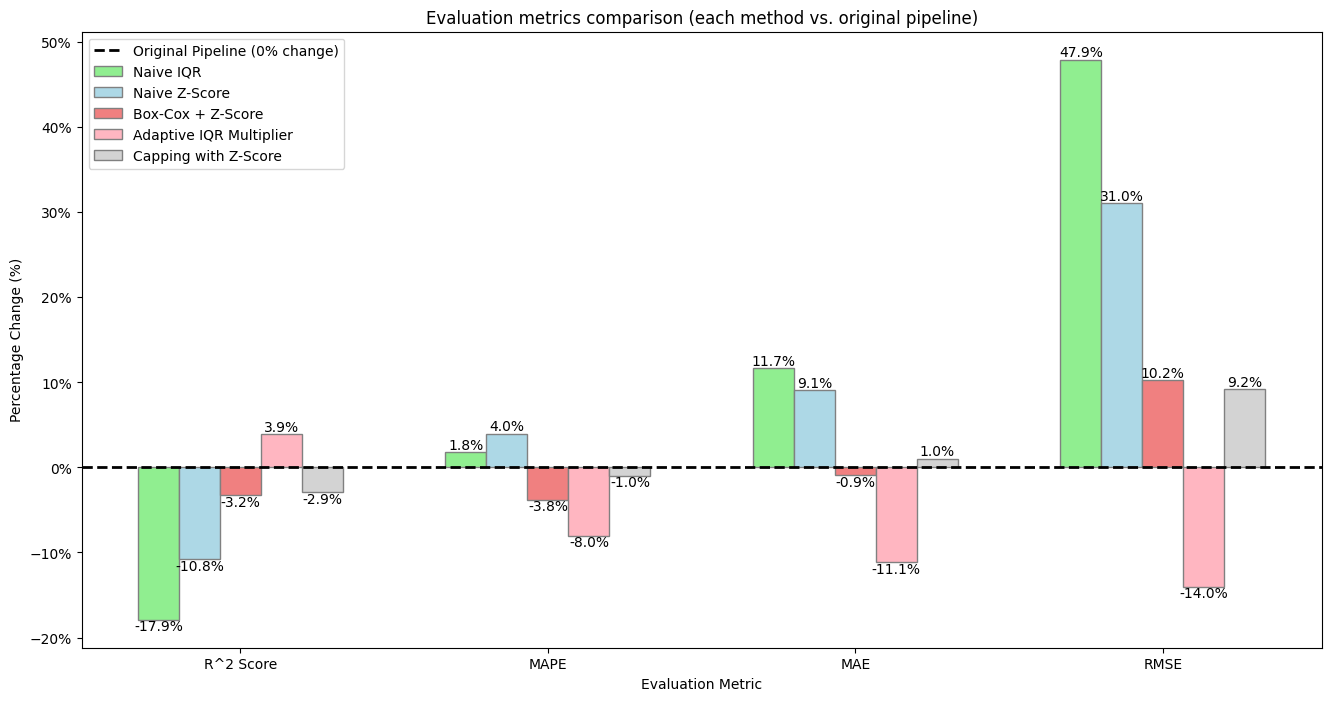

In [19]:
# Defining the evaluation metrics and their values for the original pipeline:
evaluation_metrics = ["R^2 Score", "MAPE", "MAE", "RMSE"]
original_values = results_df.loc[results_df["Method"] == "Original - no outlier handling", evaluation_metrics].values.flatten()

# Extracting the values for the evaluation metrics, for each algorithm (excluding the original pipeline, which will be used as the baseline, in a dotted line):
steps_values = [results_df.loc[results_df["Method"] == method, evaluation_metrics].values.flatten() for method in results_df["Method"] if method != "Original - no outlier handling"]

# Defining the labels for each algorithm and colors for the bars:
step_labels = [method for method in results_df["Method"] if method != "Original - no outlier handling"]
colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightpink', 'lightgrey', 'lightyellow']

# Ploting the evaluation metrics comparison:
plot_evaluation_metrics_comparison(evaluation_metrics, original_values, *steps_values, step_labels=step_labels, colors=colors)


As can be observed above, <b>the selected sub-algorithm which our adaptive algorithm has selected (Adaptive IQR Multiplier) has improved model's performance <u>by all four evaluation metrics</u></b>: the $R^2$ score is improved (increased) by 3.9%, the MAPE score is improved (decreased) by -8.0%, the MAE score is improved (decreased) by -11.1% and the RMSE score is improved (decreased) by -14.0%.
Now, since as we observed above in this case (for this dataset) our adaptive algorithm chose to perform sub-algorithm #2 (adpative IQR multiplier), I will show a part of the process conducted in order to decide on the multiplication factor of $\frac{2}{3}$ inside the formula for the adaptive IQR multiplier:

<div style="border: 1px solid blue; background-color: #f0f8ff; padding: 5px; display: inline-block;">
    <center><b>The Formula for the Adaptive IQR Multiplier:</b></center>
</div>

$$
\begin{aligned}
    adjustedIqrMultiplier &\gets 1.5+\frac{2}{3}\times (|\textbf{S}|+max(\textbf{K}-3,0)+max(\textbf{meanMedianRatio}-1.5,0) \\
    &\quad +max(\textbf{tailSpread}-3,0) + max(\textbf{outlierRate}-5\%,0))
\end{aligned}
$$


<div style="border: 1px solid blue; background-color: #f0f8ff; padding: 5px; display: inline-block;">
</div>

As can be observed, these factors are all positive and scaled with a factor of $\frac{2}{3}$, found by a search performed over several datasets as close to be optimal, intuitive and practical choice. Following is a comparison of the $R^2$ metric for this (House Prices) dataset for different values of multipliers:


In [20]:
def compute_iqr_multiplierWithSpecificCorrectionFactor(data, multiplier):
    # Calculating basic statistics - skewness and kurtosis of the data:
    skew_value = stats.skew(data)
    kurt_value = stats.kurtosis(data, fisher=True)

    # Calculating the Mean-to-Median Ratio:
    mean_value = np.mean(data)
    median_value = np.median(data)     
    if median_value != 0:
        mean_median_ratio = mean_value / median_value
    else:
        mean_median_ratio = 1


    # Calculating IQR=Q3-Q1 (1st and 3rd quartiles):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1

    # Also calculating the 1st and 99th percentiles:
    p1, p99 = np.percentile(data, [1, 99])
    # Using the 1st and 99th percentiles calculated above, we can now calculate the Tail Spread:
    if iqr != 0:
        tail_spread = (p99 - p1) / iqr
    else:
        tail_spread = 0


    # Now, I also calculate the Outlier Rate (values that are 1.5*IQR away from the 1st and 3rd quartiles):
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = np.sum((data < lower_bound) | (data > upper_bound))
    outlier_rate = outliers / len(data)

    
    # Using the developed IQR Multiplier Formula introduced in the paper:
    iqr_multiplier = 1.5 + multiplier * (
                      + abs(skew_value) 
                      + max(0, kurt_value - 3) 
                      + max(0, tail_spread - 3) 
                      + max(0, outlier_rate - 0.05)  
                      + max(0, mean_median_ratio - 1.5))
    return round(iqr_multiplier, 2)


def apply_iqr_withTailoredMultiplier(dtf_train, dtf_test, multiplier):
    # First, getting the calculated tailor-made IQR multiplier using the function above:
    iqr_multiplier = compute_iqr_multiplierWithSpecificCorrectionFactor(dtf_train[targetVariableName], multiplier)
    
    # Calculating the 1st and 3rd quartiles, and the IQR accordingly:
    Q1 = dtf_train[targetVariableName].quantile(0.25)
    Q3 = dtf_train[targetVariableName].quantile(0.75)
    IQR = Q3 - Q1

    # Based on the calculated IQR, calculating the lower and upper bounds (using the calculated multiplier):
    # It is important to note the use of 'iqr_multiplier', which is the calculated multiplier (according to the formula explained in the article), rather than using the generic 1.5 multiplier:
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Now, removing the outliers (values that are more than iqr_multiplier*IQR away from the 1st and 3rd quartiles):
    dtf_train = dtf_train[(dtf_train[targetVariableName] >= lower_bound) & (dtf_train[targetVariableName] <= upper_bound)]
    return dtf_train, dtf_test, iqr_multiplier


def train_and_evaluateWithFactor(dtf_train, dtf_test, factor):
    # Splitting the data into X and y:
    X_train = dtf_train.drop([targetVariableName], axis=1)
    X_test = dtf_test.drop([targetVariableName], axis=1)
    y_train = dtf_train[targetVariableName]
    y_test = dtf_test[targetVariableName]
    
    # Training the model (XGBoost):
    model = XGBRegressor()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # The four evaluation metrics used, and also the factor used for the IQR method:
    metrics = {
        "Factor": factor,
        "R^2 Score": r2_score(y_test, predictions),
        "MAPE": mean_absolute_percentage_error(y_test, predictions),
        "MAE": mean_absolute_error(y_test, predictions),
        "RMSE": np.sqrt(mean_squared_error(y_test, predictions))
    }
    
    return metrics

# Defining a list with the multipliers I want to test:
multipliers = [0.1, 0.2, 0.3, 0.33, 0.4, 0.5, 0.6, (2/3), 0.7, 0.8, 0.9, 1]
results = []
# I will iterate over all these multipliers, and for each one, I will apply the IQR method with the tailored multiplier (and save the resulting evaluation metric scores):
for multiplier in multipliers:
    modified_train, modified_test, total_iqr_multiplier = apply_iqr_withTailoredMultiplier(dtf_train.copy(), dtf_test.copy(), multiplier)
    # Important - I call the function 'train_and_evaluateWithFactor' which is the same as 'train_and_evaluate', but also uses the specified multiplier for IQR method!
    metrics = train_and_evaluateWithFactor(modified_train, modified_test, f"{multiplier:.2f}")
    metrics["IQR Multiplier"] = total_iqr_multiplier
    # Saving the results for the current multiplier:
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df = results_df[['Factor', 'IQR Multiplier', 'R^2 Score', 'MAPE', 'MAE', 'RMSE']]
print(results_df)

   Factor  IQR Multiplier  R^2 Score      MAPE           MAE          RMSE
0    0.10            2.05   0.802740  0.110045  19587.022983  38897.954240
1    0.20            2.59   0.785309  0.116820  20421.967345  40580.197231
2    0.30            3.14   0.834396  0.112830  19606.209800  35640.384984
3    0.33            3.30   0.834926  0.109629  18921.358465  35583.325222
4    0.40            3.69   0.830150  0.109162  19157.123702  36094.341826
5    0.50            4.23   0.833556  0.109245  19166.655233  35730.612214
6    0.60            4.78   0.837013  0.111672  19375.592934  35357.631675
7    0.67            5.14   0.903189  0.106062  17220.163380  27250.139316
8    0.70            5.33   0.903189  0.106062  17220.163380  27250.139316
9    0.80            5.87   0.903189  0.106062  17220.163380  27250.139316
10   0.90            6.42   0.869101  0.115332  19372.175714  31686.522696
11   1.00            6.96   0.869101  0.115332  19372.175714  31686.522696


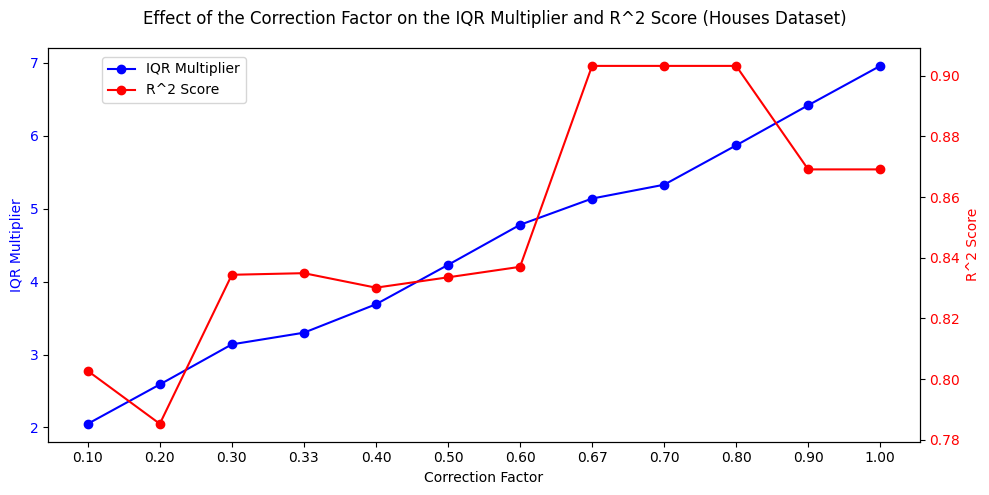

In [21]:
# Creating a plot to visualize the effect of the correction factor on the IQR Multiplier and the four evaluation metrics:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting the IQR Multiplier on the y-axis:
ax1.plot(results_df["Factor"], results_df["IQR Multiplier"], marker='o', label="IQR Multiplier", color='b')
ax1.set_xlabel("Correction Factor")
ax1.set_ylabel("IQR Multiplier", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating ANOTHER y-axis for R^2 Score (one of the y-axes is on the left, and the other in on the right, and there are two lines in different colors, each for a different y-axis):
ax2 = ax1.twinx()
ax2.plot(results_df["Factor"], results_df["R^2 Score"], marker='o', label="R^2 Score", color='r')
ax2.set_ylabel("R^2 Score", color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.suptitle("Effect of the Correction Factor on the IQR Multiplier and R^2 Score (Houses Dataset)")
fig.tight_layout()
# Showing a legend for both lines:
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
# The following line was used in order to save the plot as a PDF file (to be added as a figure in the article):
# plt.savefig('correlationFactorEffect.pdf', bbox_inches='tight')
plt.show()


This figure above shows both the <i>IQR Multiplier</i> that is used and the resulting <i>$R^2$ score</i> as a function of the correction factor; as can be observed, <b>the <i>optimum value</i> for the correction factor is around 0.7</b> (until 0.8, as the correction factor increases the R^2 score increases as well, but after that we see that trend flips)). <b><i>Therefore, a correction factor of $\frac{2}{3}$ is chosen</i></b>. Similar optimization on other datasets showed that $\frac{2}{3}$ is <i>consistently</i> close to the optimal factor.  This type of optimization was performed on other datasets, and a correction factor of 2/3 is consistently close to the optimal one.

<b>The following plot shows a comparison between the PIM score I have developed for our adaptive algorithm (which chose to perform the adaptive IQR multiplier sub-algorithm) and the PIM score of the most relevant baseline algorithm</b> (naive IQR, with the common and fixed 1.5 multiplier); we can see that our algorithm dramatically outperforms the baseline algorithm! In fact, while the baseline algorithm only degarded the model's performance compared to the original pipeline, our algorithm has improved the PIM score by more than 9% compared to the original pipeline, which is relatively an excellent improvement. Our algorithm not only achieved better performance compared to the original pipeline, <b>but also compared to the popular and commonly used fixed 1.5 IQR multiplier baseline method for detecting outliers. <u>This indicates that the formula presented as part of this sub-algorithm indeed succeeds in creating a tailor-made IQR multiplier, which is better than the common fixed 1.5 multiplier</u>.</b>

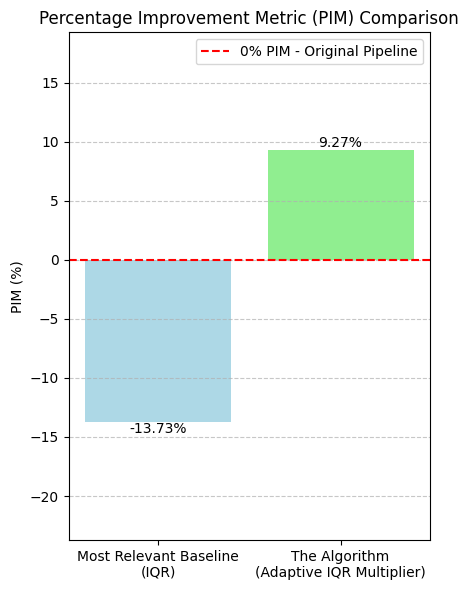

In [22]:
# Calling the function calculating the PIM score (Percentage Improvement Metric), getting the PIM scores both for the algorithm and for the most relevant baseline:
algorithm_PIM_score_housesDataset, most_relevant_baseline_PIM_score_housesDataset = calculatePIM(
    xgb_r2_originalPipeline, xgb_mape_originalPipeline, xgb_mae_originalPipeline, xgb_rmse_originalPipeline,
    xgb_r2_bestMethod, xgb_mape_bestMethod, xgb_mae_bestMethod, xgb_rmse_bestMethod,
    xgb_r2_mostRelevantBaseline, xgb_mape_mostRelevantBaseline, xgb_mae_mostRelevantBaseline, xgb_rmse_mostRelevantBaseline
)

# Call the function with the appropriate values
plot_pim_comparison(most_relevant_baseline_PIM_score_housesDataset, algorithm_PIM_score_housesDataset, "IQR", "Adaptive IQR Multiplier")


---
# <b>2nd Dataset: Diamond Prices dataset</b>
This is the dataset which I have used for the two previous assignments in this course, having 219,703 records.</br>
> **Reference**: [<b>the largest diamond dataset currently available on Kaggle</b>](https://www.kaggle.com/datasets/hrokrin/the-largest-diamond-dataset-currely-on-kaggle/data).

<b>Loading the dataset and getting the model's performance according to the original pipeline (NO outlier handling):</b><br>
Note: this dataset (which I have used for the two previous submissions in the course) requires performing more thorough data-cleaning process; I will perform the same data-cleaning I have conducted during the previous two submissions for that dataset.

In [23]:
dtf = pd.read_csv("./data/diamonds.csv",index_col=0)
targetVariableName = 'total_sales_price'

print("2nd dataset (Diamonds) - Original Pipeline Performance:")
# Printing the number of rows in the dataset:
print("Number of rows in the dataset: ", len(dtf))

# Now I create a dtf, consisting of the detailed columns:
cols = ["cut","color","clarity", "carat_weight", "cut_quality", "lab", "symmetry", "polish", "eye_clean", "culet_size", "culet_condition", "depth_percent", "table_percent", "meas_length", "meas_width", "meas_depth",
        "girdle_min", "girdle_max", "fluor_color", "fluor_intensity", "fancy_color_dominant_color", "fancy_color_secondary_color", "fancy_color_overtone", "fancy_color_intensity", "total_sales_price"]
dtf = dtf[cols]


# First of all, as we did in class, we divide the data into training and testing sets:
# Using 80% of the data for training and 20% for testing, and setting a random seed for reproducibility (we want to get the same results every time we run the code, and I saw that it is a common value to use):
dtf_train, dtf_test = train_test_split(dtf, test_size=0.2, random_state=42)

# Dealing with missing values:
# Filling missing values with "unknown" for the "fluor_intensity" and "fancy_color_overtone" columns:
dtf_train["fluor_intensity"] = dtf_train["fluor_intensity"].fillna("unknown")
dtf_test["fluor_intensity"] = dtf_test["fluor_intensity"].fillna("unknown")

# Filling missing values with "unknown" for the "fancy_color_overtone" column:
dtf_train["fancy_color_overtone"] = dtf_train["fancy_color_overtone"].fillna("unknown")
dtf_test["fancy_color_overtone"] = dtf_test["fancy_color_overtone"].fillna("unknown")

# "One-Hot-Encoding" for the categorical columns:
# Taking only the categorial columns (we can find them by selecting the columns with the type 'object'):
categorialCols = dtf.select_dtypes(include=['object']).columns
cols = categorialCols

# 'cols' are the categorial columns that we want to convert to dummy columns:
# So, now we use the code presented in class, and convert each such categorial feature to dummy columns and add them to the dataframe:
for col in cols:
    dummy_train = pd.get_dummies(dtf_train[col], prefix=col)
    dtf_train = pd.concat([dtf_train, dummy_train], axis=1)
    dtf_train = dtf_train.drop(col, axis=1)
    
    dummy_test = pd.get_dummies(dtf_test[col], prefix=col)
    dtf_test = pd.concat([dtf_test, dummy_test], axis=1)
    dtf_test = dtf_test.drop(col, axis=1)


2nd dataset (Diamonds) - Original Pipeline Performance:
Number of rows in the dataset:  219703


At that point, it is important to make sure that the train and test sets have the same number of columns after applying One-Hot-Encoding to the categorial columns, otherwise the model will not be able to make predictions on the test set.
<b>The problem may arise if the train and test sets have different values in the categorial columns, which will result in different dummy columns being created for the train and test sets</b>.
It should be noted that in other implementations of One-Hot-Encoding, this problem is already taken care of, but I sticked to the code presented in class (and used in the previous two submissions), so I will add below code dealing with this issue.

In [24]:
# We check whether the train and test sets have the same number of columns after converting the categorial columns to dummy columns, doing One-Hot-Encoding to the categorial columns:
if len(dtf_train.columns) == len(dtf_test.columns):
    print("The train and test sets have the same number of columns after applying One-Hot-Encoding to the categorial columns.")
else:
    print("The train and test sets have different number of columns after applying One-Hot-Encoding to the categorial columns.")
    print("Num of columns in the train set is:", len(dtf_train.columns), ". The num of columns in the test set is:", len(dtf_test.columns))

The train and test sets have different number of columns after applying One-Hot-Encoding to the categorial columns.
Num of columns in the train set is: 152 . The num of columns in the test set is: 143


So, we understand that there are 152 columns in the train set, but only 143 columns in the test set.
<br>
This does not necessarily mean that there are 9 more columns in the train set; maybe 10 columns appear only in the train set, but 8 appear only in the test set. Therefore, I will check whether this is the case:

In [25]:
# We print the columns which appear in the training set, but do not appear in the test set:
cols_only_in_train = [x for x in dtf_train.columns if x not in dtf_test.columns]
print("columns which appear in the training set, but do not appear in the test set:", cols_only_in_train)

# We print the columns which appear in the test set, but do not appear in the training set:
cols_only_in_test = [x for x in dtf_test.columns if x not in dtf_train.columns]
print("columns which appear in the test set, but do not appear in the training set:", cols_only_in_test)


columns which appear in the training set, but do not appear in the test set: ['cut_quality_Fair', 'cut_quality_Ideal', 'polish_Fair', 'culet_size_EL', 'culet_size_VL', 'girdle_max_STN', 'fancy_color_dominant_color_Other', 'fancy_color_secondary_color_Red', 'fancy_color_overtone_Grayish']
columns which appear in the test set, but do not appear in the training set: []


From the results of the code cell above, we can clearly see that there are 9 columns which appear in the train set, but not in the test set.
<br>
On the other hand, as we have verified in the code cell above, there are no columns appearing only in the test set (and not in the train set).
<br>
Let's see the nature these columns, that appear only in the train set:

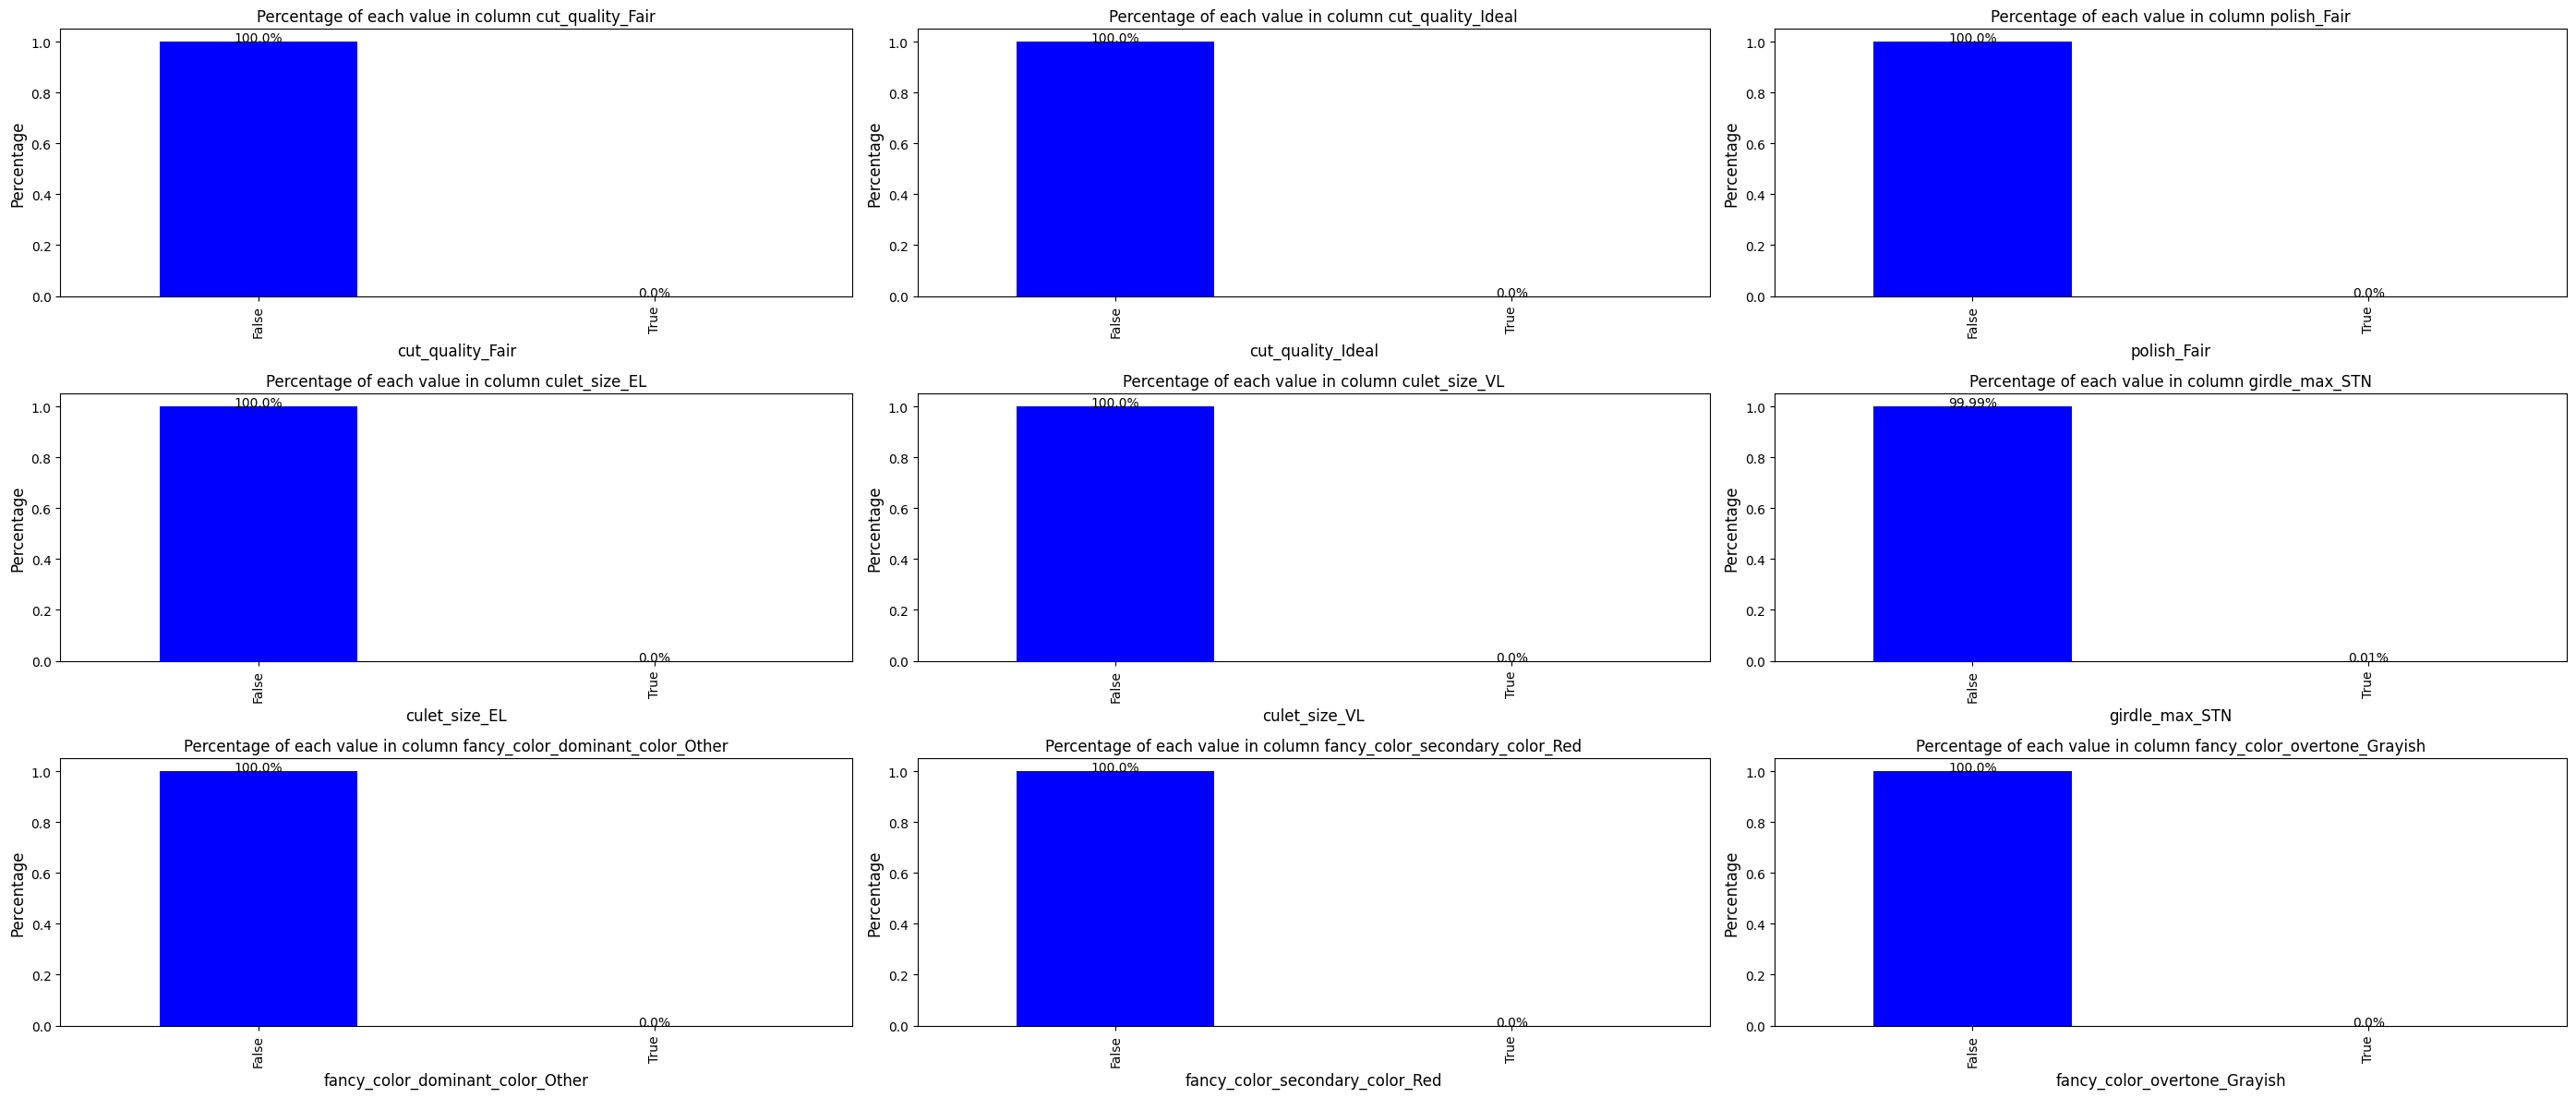

In [26]:
# Drawing a graph showing the different values of each column in cols_only_in_train, presenting the percentage of each value:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(28, 12))
axes = axes.flatten()

for i, col in enumerate(cols_only_in_train):
    dtf_train[col].value_counts(normalize=True).plot(kind='bar', color='blue', ax=axes[i])
    axes[i].set_ylabel('Percentage', fontsize=12)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_title('Percentage of each value in column ' + col, fontsize=12)
    for j in range(len(dtf_train[col].unique())):
        axes[i].text(j, dtf_train[col].value_counts(normalize=True)[j], 
                     str(round(dtf_train[col].value_counts(normalize=True)[j]*100, 2)) + "%", ha='center')

plt.tight_layout()
plt.show()


We can see that 100% of the records in the train have 'False' value for each of the columns that appear only in the train set! Therefore, we can drop these columns from the train and test sets, as they do not provide the model any extra information! (thus also fixing the problem of non-matching number of columns, between the train set and the test set).

In [27]:
# Removing from the train set these columns which are in the training set but not in the test set:
missingCols = [x for x in dtf_train.columns if x not in dtf_test.columns]
dtf_train = dtf_train.drop(missingCols, axis=1)

# We check whether the train and test sets have the same number of columns after converting the categorial columns to dummy columns, doing One-Hot-Encoding to the categorial columns:
if len(dtf_train.columns) == len(dtf_test.columns):
    print("The train and test sets have the same number of columns after applying One-Hot-Encoding to the categorial columns, which is", len(dtf_train.columns), "columns.")
else:
    print("The train and test sets have different number of columns after applying One-Hot-Encoding to the categorial columns.")
    print("Num of columns in the train set is:", len(dtf_train.columns), ". The num of columns in the test set is:", len(dtf_test.columns))


The train and test sets have the same number of columns after applying One-Hot-Encoding to the categorial columns, which is 143 columns.


Now, we can move on to the next step, which is building a machine learning model to predict the price of diamonds (this will be the basic, original pipeline), and getting the initial model performance, according to the original pipeline:</b>

In [28]:
# Separating X from y (X are the features, y is the target variable):
X_train = dtf_train.drop('total_sales_price',axis=1)
X_test = dtf_test.drop('total_sales_price',axis=1)

y_train = dtf_train['total_sales_price']
y_test = dtf_test['total_sales_price']

# Initializing the XGBoost regressor model:
xgb_model = XGBRegressor()

# Training the model on the training data (fitted to the training data):
xgb_model.fit(X_train, y_train)

# Now, we can make predictions on the test data:
prediction = xgb_model.predict(X_test)


# Evaluating the model using the evaluation metrics we have imported above:
xgb_r2_baseline = r2_score(y_test, prediction)
xgb_mape_baseline = mean_absolute_percentage_error(y_test, prediction)
xgb_mae_baseline = mean_absolute_error(y_test, prediction)
xgb_rmse_baseline = np.sqrt(mean_squared_error(y_test, prediction))

# Print the evaluation metrics
print(f"R^2 Score: {xgb_r2_baseline:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {xgb_mape_baseline:.3f}")
print(f"Mean Absolute Error (MAE): {xgb_mae_baseline:.0f}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse_baseline:.0f}")


R^2 Score: 0.856
Mean Absolute Percentage Error (MAPE): 0.145
Mean Absolute Error (MAE): 1141
Root Mean Squared Error (RMSE): 10567


### <b>Which sub-algorithm would our algorithm choose to apply for this dataset, and why?</b>

In [29]:
# Using our adaptive data-driven algorithm (implemented above) for selecting the most relevant sub-algorithm for the dataset:
print(select_outlier_method(dtf_train, targetVariableName, True))

Skewness:  18.425195127080165
Normalized Variance:  13.602890154126007
Box-Cox + Z-Score


Since this dataset is highly skewed (<i>skewness</i> of $18>3$), according to the adaptive algorithm, it chooses to perform sub-algorithm #1 <b>(<i>Box-Cox + Z-Score</i>)</b>.
<br> 
<b>First, to present the absolute numbers I will present a table</b> with the performance of the model after according to the original pipeline OR after applying each of the 2 baseline algorithms OR after applying each of the 3 sub-algorithms introduced in this project; this table is presented above, <b>and afterwards I will show plots presenting that information clearly, but in graphic display</b>.

In [30]:
# I create a list storing the results of each evaluation metric (R^2, MAPE, MAE, RMSE) for each of the 6 outlier removal methods:
results = []
# Iterating through all the six algorithms (the original pipeline, the two baseline algorithms, and the three sub-algorithms):
for method_name, method in methods.items():
    modified_train, modified_test = method(dtf_train.copy(), dtf_test.copy(), targetVariableName)
    metrics = train_and_evaluate(modified_train, modified_test, method_name, targetVariableName)
    # Saving the results for the current algorithm:
    results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df)

                           Method  R^2 Score      MAPE          MAE  \
0  Original - no outlier handling   0.856255  0.145464  1141.456891   
1                       Naive IQR   0.070101  0.130793  3412.422393   
2                   Naive Z-Score   0.324081  0.115967  1846.356382   
3               Box-Cox + Z-Score   0.860972  0.141643  1129.936733   
4         Adaptive IQR Multiplier   0.166863  0.110115  2509.613803   
5            Capping with Z-Score   0.318585  0.116224  1860.573614   

           RMSE  
0  10566.866073  
1  26876.158383  
2  22913.786606  
3  10392.018584  
4  25439.451843  
5  23006.752860  


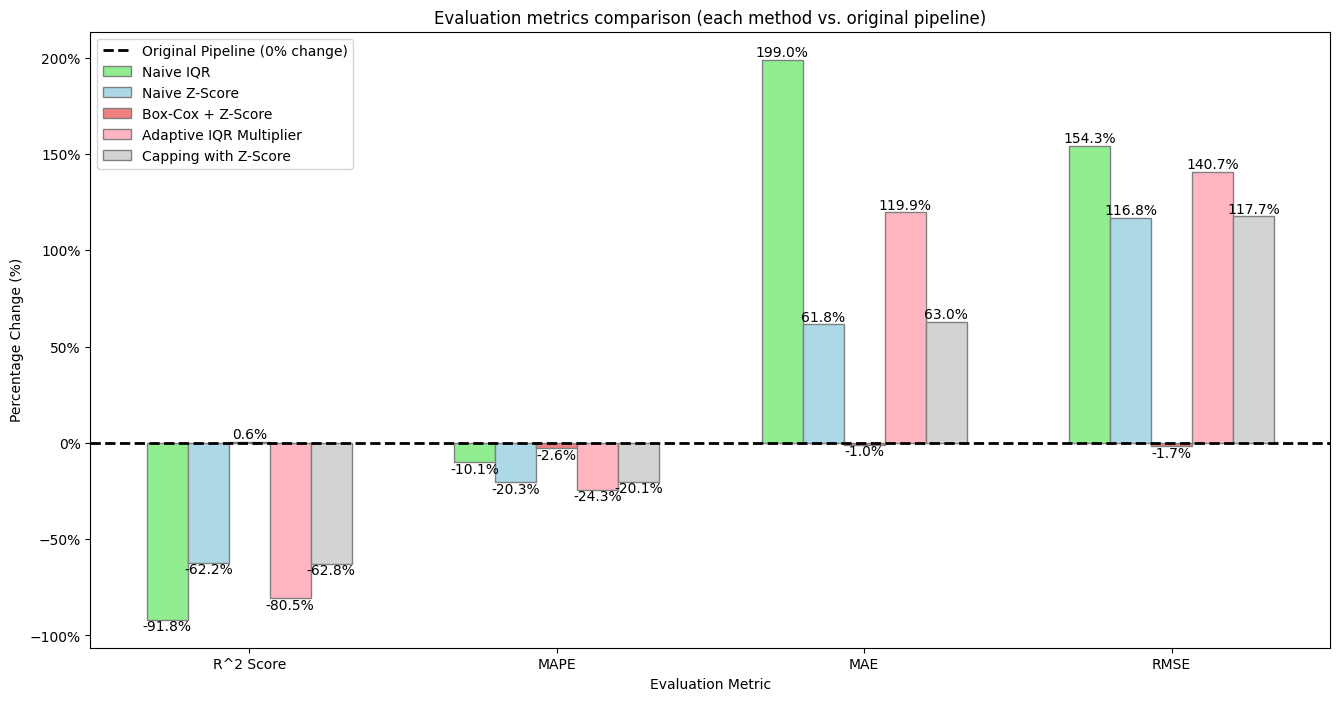

In [31]:
# Defining the evaluation metrics and their values for the original pipeline:
evaluation_metrics = ["R^2 Score", "MAPE", "MAE", "RMSE"]
original_values = results_df.loc[results_df["Method"] == "Original - no outlier handling", evaluation_metrics].values.flatten()

# Extracting the values for the evaluation metrics, for each algorithm (excluding the original pipeline, which will be used as the baseline, in a dotted line):
steps_values = [results_df.loc[results_df["Method"] == method, evaluation_metrics].values.flatten() for method in results_df["Method"] if method != "Original - no outlier handling"]

# Defining the labels for each algorithm and colors for the bars:
step_labels = [method for method in results_df["Method"] if method != "Original - no outlier handling"]
colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightpink', 'lightgrey', 'lightyellow']

# Ploting the evaluation metrics comparison:
plot_evaluation_metrics_comparison(evaluation_metrics, original_values, *steps_values, step_labels=step_labels, colors=colors)

Similar to the previous case, <b>the proposed algorithm outperforms all baselines</b> while the most relevant baseline algorithm (regular Z-Score outlier-removal) <u>only worsens the model's performance, by almost all evaluation metrics</u>. The baseline algorithm is so counterproductive that it lowers the $R^2$ score by 62% and increases RMSE by 116%! In other words, the problem is not the use of the Z-score method but using it on data which is not close to the normal distribution; however, performing Box-Cox transformation as a preliminary de-skewing step before applying the Z-score method deals with the outliers much better. 
As can be observed above, <b>the selected sub-algorithm which our adaptive algorithm has selected (Box-Cox + Z-Score) has improved model's performance <u>by all four evaluation metrics</u></b>: the $R^2$ score is improved (increased) by 0.6%, the MAPE score is improved (decreased) by -2.6%, the MAE score is improved (decreased) by -1.0% and the RMSE score is improved (decreased) by -1.7%. Moreover, we can see that any alternative sub-algorithm or baseline algorithm we could choose to apply would significantly decrease model's performance (especially its RMSE score, by more than 115%, but also MAE and $R^2$ scores); this indicates that our adapative algorithm indeed chose wisely the appropriate sub-algorithm to apply in this case, based on the specific dataset characteristics.

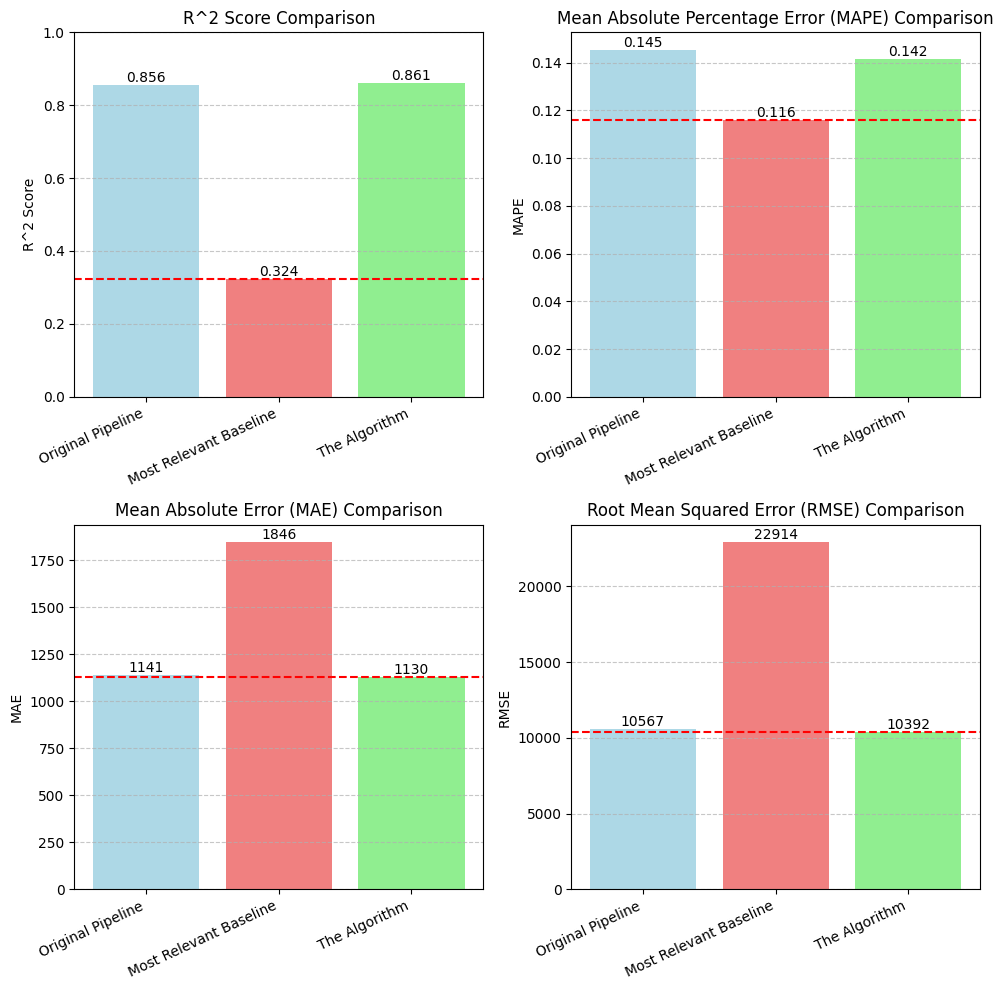

In [32]:
# Extracting the values from the results_df
xgb_r2_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "R^2 Score"].values[0]
xgb_mape_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "MAPE"].values[0]
xgb_mae_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "MAE"].values[0]
xgb_rmse_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "RMSE"].values[0]

xgb_r2_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "R^2 Score"].values[0]
xgb_mape_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "MAPE"].values[0]
xgb_mae_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "MAE"].values[0]
xgb_rmse_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "RMSE"].values[0]

xgb_r2_bestMethod = results_df.loc[results_df["Method"] == "Box-Cox + Z-Score", "R^2 Score"].values[0]
xgb_mape_bestMethod = results_df.loc[results_df["Method"] == "Box-Cox + Z-Score", "MAPE"].values[0]
xgb_mae_bestMethod = results_df.loc[results_df["Method"] == "Box-Cox + Z-Score", "MAE"].values[0]
xgb_rmse_bestMethod = results_df.loc[results_df["Method"] == "Box-Cox + Z-Score", "RMSE"].values[0]

# Calling the function to plot the comparison - plotting a graph comparing each of the 4 evaluation metrics for the original pipeline and the improved pipeline:
plot_comparison(xgb_r2_originalPipeline, xgb_mape_originalPipeline, xgb_mae_originalPipeline, xgb_rmse_originalPipeline,
                xgb_r2_mostRelevantBaseline, xgb_mape_mostRelevantBaseline, xgb_mae_mostRelevantBaseline, xgb_rmse_mostRelevantBaseline,
                xgb_r2_bestMethod, xgb_mape_bestMethod, xgb_mae_bestMethod, xgb_rmse_bestMethod)


The plot above also shows that <b>the proposed algorithm not only outperforms the original pipeline performance, but also significantly outperforms the baseline outlier-handling algorithm;</b> In fact, the baseline algorithm (naive Z-Score outlier handling) <u>worsens the model's performance, by all four evaluation metrics</u>! (doing nothing is better than using naive Z-Score outlier-removal). The selected sub-algorithm, performing <i>Box-Cox transformation</i> before applying the Z-Score method for outlier detection, yields a performance improvement (contrary to the baseline Z-Score algorithm).
In other words, the problem was not the use of Z-Score, but using it with data which is heavily skewed, and not approximately normal distributed (as already explained earlier, this is a prequisite of the Z-Score method).

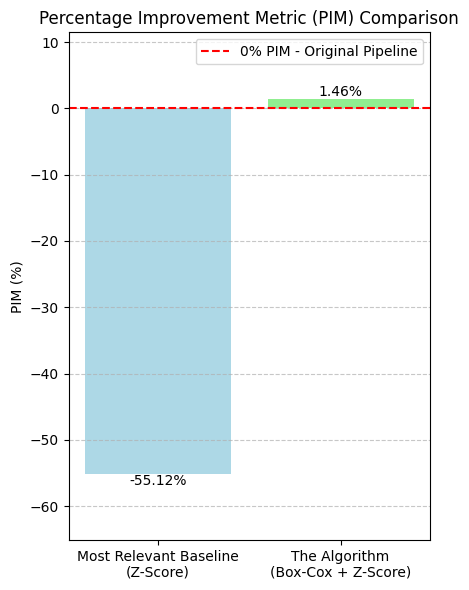

In [33]:
# Calling the function calculating the PIM score (Percentage Improvement Metric), getting the PIM scores both for the algorithm and for the most relevant baseline:
algorithm_PIM_score_diamondsDataset, most_relevant_baseline_PIM_score_diamondsDataset = calculatePIM(
    xgb_r2_originalPipeline, xgb_mape_originalPipeline, xgb_mae_originalPipeline, xgb_rmse_originalPipeline,
    xgb_r2_bestMethod, xgb_mape_bestMethod, xgb_mae_bestMethod, xgb_rmse_bestMethod,
    xgb_r2_mostRelevantBaseline, xgb_mape_mostRelevantBaseline, xgb_mae_mostRelevantBaseline, xgb_rmse_mostRelevantBaseline
)

# Call the function with the appropriate values
plot_pim_comparison(most_relevant_baseline_PIM_score_diamondsDataset, algorithm_PIM_score_diamondsDataset, "Z-Score", "Box-Cox + Z-Score")


<b>This plot shows a comparison between the PIM score of the our adaptive algorithm (which chose to perform the Box-Cox + Z-Score sub-algorithm) and the PIM score of the most relevant baseline algorithm</b> (naive Z-Score); we can see that our algorithm dramatically outperforms the baseline algorithm! In fact, while the baseline algorithm only degarded the model's performance compared to the original pipeline (by more than -55%!), our algorithm not only achieved better performance compared to the original pipeline, <b>but also compared to the popular and commonly used naive Z-Score method for detecting outliers. <u>This indicates that applying Box-Cox transformation as a preliminary step,  before using the Z-Score method for outlier detection, indeed succeeds in addressing the issue of data with distribution which is not close to the normal distribution, which yields better model performance</u>.</b>

---
# <b>3rd Dataset: Insurance Prices dataset</b>
This dataset, having 1,338 records, contains information on the relationship between personal attributes (age, gender, BMI, family size, smoking habits), geographic factors, and their impact on medical insurance charges. It can be used to study how these features influence insurance costs.</br>
> **Reference**: [<b>link to the dataset on Kaggle</b>](https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance?resource=download).

<b>Loading the dataset and getting the model's performance according to the original pipeline (NO outlier handling):</b>

In [34]:
dtf = pd.read_csv("./data/insurance.csv",index_col=0)
targetVariableName = 'charges'

print("3rd dataset (Insurance) - Original Pipeline Performance:")
# Printing the number of rows in the dataset:
print("Number of rows in the dataset: ", len(dtf))
# Splitting the data into training and testing sets:
dtf_train, dtf_test = train_test_split(dtf, test_size=0.2, random_state=42)
# Looking at the categorial columns to handle them (we can find them by selecting the columns with the type 'object'):
categorialCols = dtf.select_dtypes(include=['object']).columns

# Now we use the code presented in class, and convert each such categorial feature to dummy columns and add them to the dataframe:
for col in categorialCols:
    dummy_train = pd.get_dummies(dtf_train[col], prefix=col)
    dtf_train = pd.concat([dtf_train, dummy_train], axis=1)
    dtf_train = dtf_train.drop(col, axis=1)
    
    dummy_test = pd.get_dummies(dtf_test[col], prefix=col)
    dtf_test = pd.concat([dtf_test, dummy_test], axis=1)
    dtf_test = dtf_test.drop(col, axis=1)
    

# We check whether the train and test sets have the same number of columns after converting the categorial columns to dummy columns, doing One-Hot-Encoding to the categorial columns:
if len(dtf_train.columns) != len(dtf_test.columns):
    print("The train and test sets have different number of columns after applying One-Hot-Encoding to the categorial columns.")
    print("Num of columns in the train set is:", len(dtf_train.columns), ". The num of columns in the test set is:", len(dtf_test.columns))

# Chekcing for missing values in the dataset:
missing_values = dtf.isnull().sum().sum()
if missing_values != 0:
    print("Number of missing values in the dataset: ", missing_values)



# Separating X from y (X are the features, y is the target variable):
X_train = dtf_train.drop('charges',axis=1)
X_test = dtf_test.drop('charges',axis=1)
y_train = dtf_train['charges']
y_test = dtf_test['charges']

# Initializing the XGBoost regressor model:
xgb_model = XGBRegressor()
# Training the model on the training data (fitted to the training data):
xgb_model.fit(X_train, y_train)

# Now, we can make predictions on the test data:
prediction = xgb_model.predict(X_test)

# Evaluating the model using the evaluation metrics we have imported above:
xgb_r2_baseline = r2_score(y_test, prediction)
xgb_mape_baseline = mean_absolute_percentage_error(y_test, prediction)
xgb_mae_baseline = mean_absolute_error(y_test, prediction)
xgb_rmse_baseline = np.sqrt(mean_squared_error(y_test, prediction))

# Print the evaluation metrics
print(f"R^2 Score: {xgb_r2_baseline:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {xgb_mape_baseline:.3f}")
print(f"Mean Absolute Error (MAE): {xgb_mae_baseline:.0f}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse_baseline:.0f}")

3rd dataset (Insurance) - Original Pipeline Performance:
Number of rows in the dataset:  1338
R^2 Score: 0.713
Mean Absolute Percentage Error (MAPE): 0.884
Mean Absolute Error (MAE): 5079
Root Mean Squared Error (RMSE): 6674


### <b>Which sub-algorithm would our algorithm choose to apply for this dataset, and why?</b>

In [35]:
# Using our adaptive data-driven algorithm (implemented above) for selecting the most relevant sub-algorithm for the dataset:
print(select_outlier_method(dtf_train, targetVariableName, True))

Skewness:  1.513301477525079
Normalized Variance:  0.8103253561322599
Capping with Z-Score


Since the <i>skewness</i> of this dataset is 1.51 ($<3$) and its <i>Normalized Variance</i> is 0.81 ($>\frac{1}{2}$), according to the adaptive algorithm, sub-algorithm #3 (<b><i>Capping + Z-Score</i>)</b> will be applied and its relevant baseline is the <i>naive Z-score</i>. 
<br><br>
<b>First, to present the absolute numbers I will present a table</b> with the performance of the model after according to the original pipeline OR after applying each of the 2 baseline algorithms OR after applying each of the 3 sub-algorithms introduced in this project; this table is presented above, <b>and afterwards I will show plots presenting that information clearly, but in graphic display</b>.

In [36]:
# I create a list storing the results of each evaluation metric (R^2, MAPE, MAE, RMSE) for each of the 6 outlier removal methods:
results = []
# Iterating through all the six algorithms (the original pipeline, the two baseline algorithms, and the three sub-algorithms):
for method_name, method in methods.items():
    modified_train, modified_test = method(dtf_train.copy(), dtf_test.copy(), targetVariableName)
    metrics = train_and_evaluate(modified_train, modified_test, method_name, targetVariableName)
    # Saving the results for the current algorithm:
    results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df)

                           Method  R^2 Score      MAPE          MAE  \
0  Original - no outlier handling   0.713120  0.883820  5078.630954   
1                       Naive IQR   0.655258  0.907792  5568.863179   
2                   Naive Z-Score   0.704872  0.898218  5046.595893   
3               Box-Cox + Z-Score   0.713120  0.883820  5078.630954   
4         Adaptive IQR Multiplier   0.716781  0.864057  4973.159699   
5            Capping with Z-Score   0.738034  0.850215  4766.945060   

          RMSE  
0  6673.664030  
1  7315.791620  
2  6768.920074  
3  6673.664030  
4  6630.947691  
5  6377.295192  


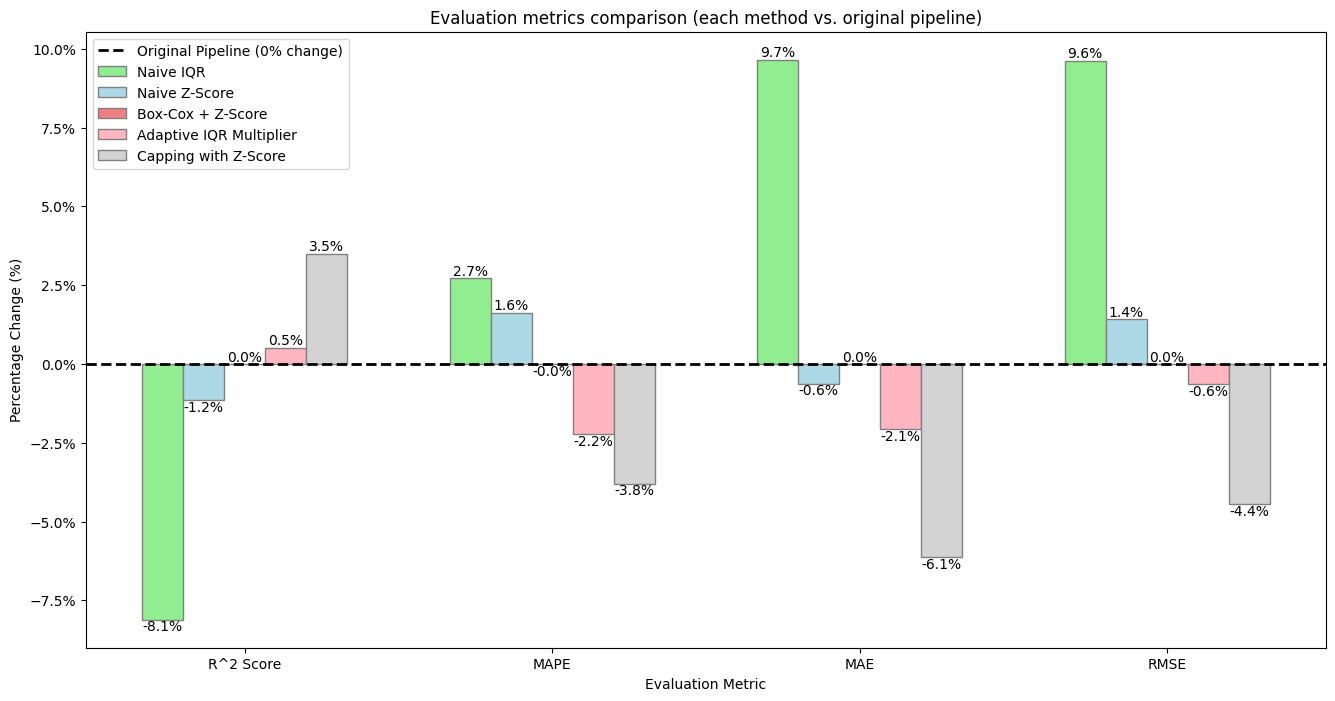

In [37]:
# Defining the evaluation metrics and their values for the original pipeline:
evaluation_metrics = ["R^2 Score", "MAPE", "MAE", "RMSE"]
original_values = results_df.loc[results_df["Method"] == "Original - no outlier handling", evaluation_metrics].values.flatten()

# Extracting the values for the evaluation metrics, for each algorithm (excluding the original pipeline, which will be used as the baseline, in a dotted line):
steps_values = [results_df.loc[results_df["Method"] == method, evaluation_metrics].values.flatten() for method in results_df["Method"] if method != "Original - no outlier handling"]

# Defining the labels for each algorithm and colors for the bars:
step_labels = [method for method in results_df["Method"] if method != "Original - no outlier handling"]
colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightpink', 'lightgrey', 'lightyellow']

# Ploting the evaluation metrics comparison:
plot_evaluation_metrics_comparison(evaluation_metrics, original_values, *steps_values, step_labels=step_labels, colors=colors)

Similar to the previous case, <b>the proposed algorithm outperforms all baselines</b> while the most relevant baseline algorithm (regular Z-Score outlier-removal) <u>either has lower positive effect compared to our algorithm (in terms of MAE score) or only worsens the model's performance (in terms of $R^2$, MAPE and RMSE scores)</u>; The problem is not the use of the Z-score method but the decision how to use it - to remove outliers or to cap their value - in this case, extreme values are quite frequent (high Normalized Variance) and it is better to cap them.<br>
As can be observed above, <b>the selected sub-algorithm which our adaptive algorithm has selected (capping with z-score) has improved model's performance <u>by all four evaluation metrics</u></b>: the $R^2$ score is improved (increased) by 3.5%, the MAPE score is improved (decreased) by -3.8%, the MAE score is improved (decreased) by -6.1% and the RMSE score is improved (decreased) by -4.4%.


It is interesting to notice the <b><i>lack</i> of influence</b> of sub-algorithm #1 (<i>Box-Cox + Z-Score</i>), which changes all four evaluation metrics by 0% compared to the original pipeline, which may seem as an error. However, a more thorough analysis, shows that the reason for this phenomenon stems from the <b><i>relatively non-skewed</i> distribution of the target variable in this dataset</b>:


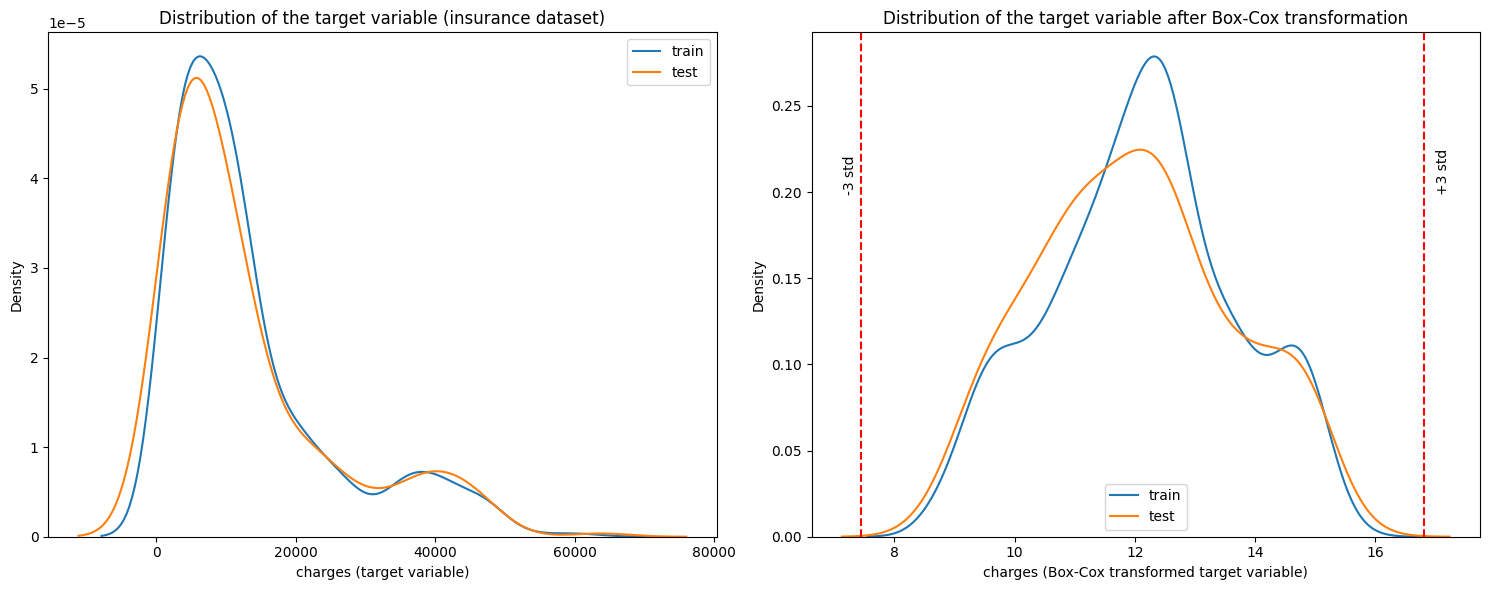

Number of values outside 3 standard deviations in the training set after box-cox transformation:  0
Number of values outside 3 standard deviations in the test set after box-cox transformation:  0


In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting a KDE plot of the target variable (without Box-Cox transformation):
sns.kdeplot(y_train, label="train", ax=axes[0])
sns.kdeplot(y_test, label="test", ax=axes[0])
axes[0].set_title("Distribution of the target variable (insurance dataset)")
axes[0].set_xlabel("charges (target variable)")
axes[0].set_ylabel("Density")
axes[0].legend()

# Plotting a KDE plot of the target variable (after peforming Box-Cox transformation):
y_train_bc, lambda_boxcox = boxcox(y_train)
y_test_bc = boxcox(y_test, lmbda=lambda_boxcox)
sns.kdeplot(y_train_bc, label="train", ax=axes[1])
sns.kdeplot(y_test_bc, label="test", ax=axes[1])
axes[1].set_xlabel("charges (Box-Cox transformed target variable)")
axes[1].set_ylabel("Density")

# Drawing red dotted lines at the mean and at +-3 standard deviations from the mean:
axes[1].axvline(y_train_bc.mean() - 3*y_train_bc.std(), color='red', linestyle='--')
axes[1].text(y_train_bc.mean() - 3*y_train_bc.std()-0.3, 0.2, "-3 std", rotation=90)
axes[1].axvline(y_train_bc.mean() + 3*y_train_bc.std(), color='red', linestyle='--')
axes[1].text(y_train_bc.mean() + 3*y_train_bc.std()+0.2, 0.2, "+3 std", rotation=90)

# Showing the plot:
axes[1].legend()
axes[1].set_title("Distribution of the target variable after Box-Cox transformation")
plt.tight_layout()
# The following line was used in order to save the plot as a PDF file (to be added as a figure in the article):
# plt.savefig('boxcoxBeforeAndAfterInsurance.pdf', bbox_inches='tight')
plt.show()

# Printing how many values are outside 3 standard deviations:
print("Number of values outside 3 standard deviations in the training set after box-cox transformation: ", len(y_train_bc[(y_train_bc < y_train_bc.mean() - 3*y_train_bc.std()) | (y_train_bc > y_train_bc.mean() + 3*y_train_bc.std())]))
print("Number of values outside 3 standard deviations in the test set after box-cox transformation: ", len(y_test_bc[(y_test_bc < y_test_bc.mean() - 3*y_test_bc.std()) | (y_test_bc > y_test_bc.mean() + 3*y_test_bc.std())]))


The original distribution (<b>left plot</b>) shows the original distribution, and after Box-Cox (<b>right plot</b>) it becomes almost normal with no data points outside $\pm3\sigma$! no outliers are found, aligning with the 0% change relative to the original pipeline, as well as supports our adaptive data-driven algorithm's choice <u>not</u> to choose this sub-algorithm (for this dataset).

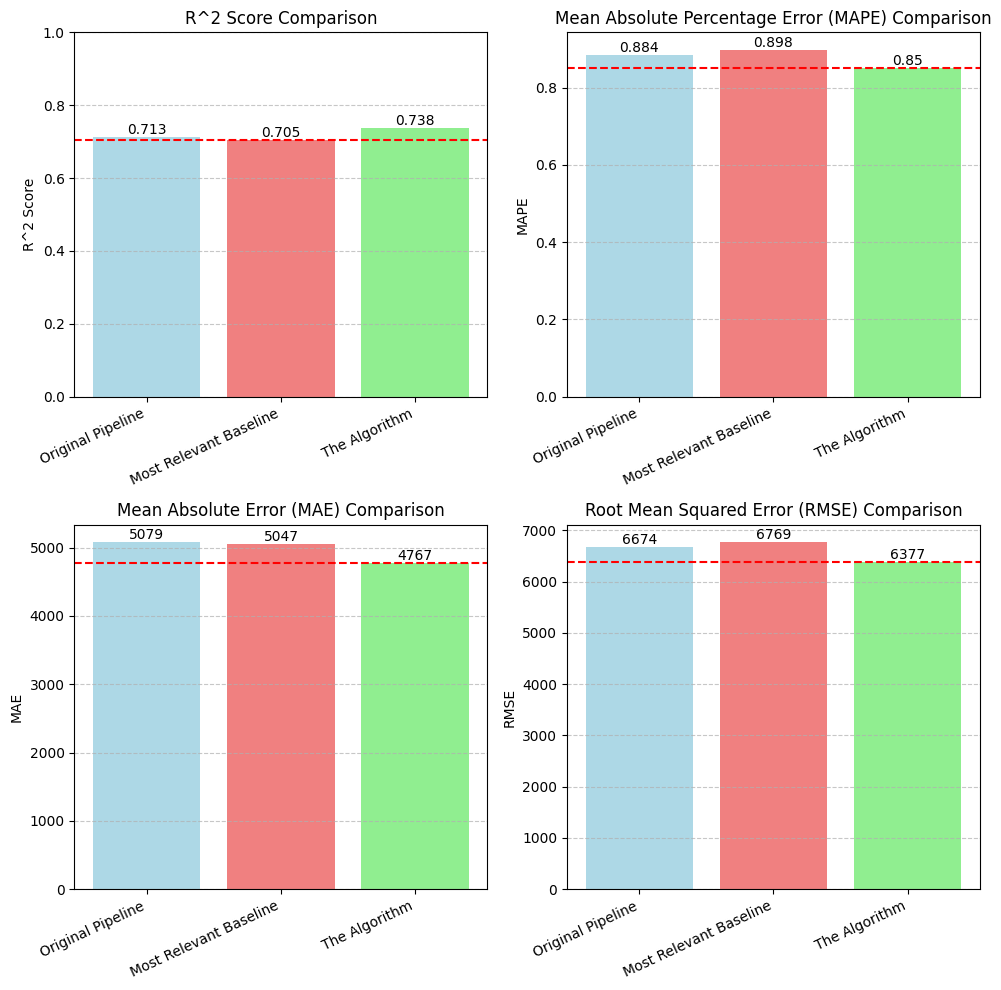

In [39]:
# Extracting the values from the results_df:
xgb_r2_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "R^2 Score"].values[0]
xgb_mape_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "MAPE"].values[0]
xgb_mae_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "MAE"].values[0]
xgb_rmse_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "RMSE"].values[0]

xgb_r2_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "R^2 Score"].values[0]
xgb_mape_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "MAPE"].values[0]
xgb_mae_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "MAE"].values[0]
xgb_rmse_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "RMSE"].values[0]

xgb_r2_bestMethod = results_df.loc[results_df["Method"] == "Capping with Z-Score", "R^2 Score"].values[0]
xgb_mape_bestMethod = results_df.loc[results_df["Method"] == "Capping with Z-Score", "MAPE"].values[0]
xgb_mae_bestMethod = results_df.loc[results_df["Method"] == "Capping with Z-Score", "MAE"].values[0]
xgb_rmse_bestMethod = results_df.loc[results_df["Method"] == "Capping with Z-Score", "RMSE"].values[0]

# Calling the function to plot the comparison - plotting a graph comparing each of the 4 evaluation metrics for the original pipeline and the improved pipeline:
plot_comparison(xgb_r2_originalPipeline, xgb_mape_originalPipeline, xgb_mae_originalPipeline, xgb_rmse_originalPipeline,
                xgb_r2_mostRelevantBaseline, xgb_mape_mostRelevantBaseline, xgb_mae_mostRelevantBaseline, xgb_rmse_mostRelevantBaseline,
                xgb_r2_bestMethod, xgb_mape_bestMethod, xgb_mae_bestMethod, xgb_rmse_bestMethod)


The plot above also shows that <b>The proposed algorithm not only outperforms the original pipeline performance, but also significantly outperforms the baseline outlier-handling algorithm;</b> While the baseline algorithm (naive Z-Score outlier handling) only slightly improves the MAE score but worsens the $R^2$, MAPE and RMSE scores (doing nothing is probably better than using naive Z-Score outlier-removal), the selected sub-algorithm, performing <i>Capping with Z-Score outlier handling</i>, yields a performance improvement (contrary to the baseline Z-Score algorithm).
In other words, the problem was not the use of Z-Score, but the removal of the outliers, which are better to be capped in this case, as our adaptive algorithms decided to perform beforehand.

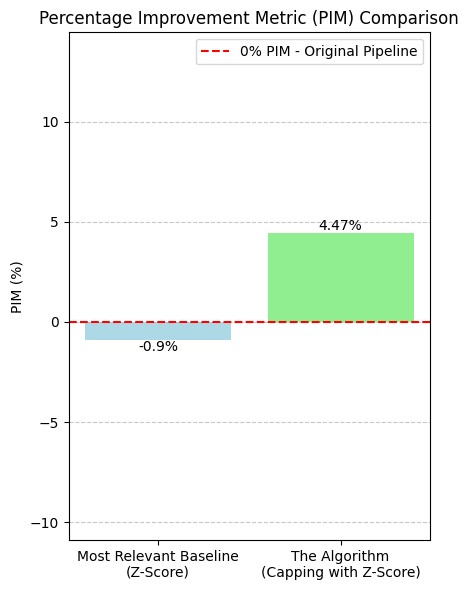

In [40]:
# Calling the function calculating the PIM score (Percentage Improvement Metric), getting the PIM scores both for the algorithm and for the most relevant baseline:
algorithm_PIM_score_insuranceDataset, most_relevant_baseline_PIM_score_insuranceDataset = calculatePIM(
    xgb_r2_originalPipeline, xgb_mape_originalPipeline, xgb_mae_originalPipeline, xgb_rmse_originalPipeline,
    xgb_r2_bestMethod, xgb_mape_bestMethod, xgb_mae_bestMethod, xgb_rmse_bestMethod,
    xgb_r2_mostRelevantBaseline, xgb_mape_mostRelevantBaseline, xgb_mae_mostRelevantBaseline, xgb_rmse_mostRelevantBaseline
)

# Call the function with the appropriate values
plot_pim_comparison(most_relevant_baseline_PIM_score_insuranceDataset, algorithm_PIM_score_insuranceDataset, "Z-Score", "Capping with Z-Score")


<b>This plot shows a comparison between the PIM score of the our adaptive algorithm (which chose to perform the Capping with Z-Score sub-algorithm) and the PIM score of the most relevant baseline algorithm</b> (naive Z-Score); we can see that our algorithm dramatically outperforms the baseline algorithm! In fact, while the baseline algorithm only degarded the model's performance compared to the original pipeline, our algorithm not only achieved better performance compared to the original pipeline (improved the PIM score by more than 4.4% compared to the original pipeline, which is relatively a very good improvement), <b>but also compared to the popular and commonly used naive Z-Score method for detecting outliers. <u>This indicates that indeed, as our adaptive algorithm decided to perform beforehand, for this dataset, it is better to cap the outliers (but do capping only to outliers recognized according to Z-Score outlier detection) rather than removing them, thus achieving better model performance</u>.</b>

---
# <b>4th Dataset: Car Prices dataset</b>
This dataset, having 8,128 records, contains various features related to cars, including the year of manufacture, selling price, kilometers driven, fuel type, etc. This data may be used for evaluating the selling price of cars.</br>
> **Reference**: [<b>link to the dataset on Kaggle</b>](https://www.kaggle.com/datasets/sukhmandeepsinghbrar/car-price-prediction-dataset).

<b>Loading the dataset and getting the model's performance according to the original pipeline (NO outlier handling):</b>

In [41]:
dtf = pd.read_csv("./data/cardekho4.csv",index_col=0)
targetVariableName = 'selling_price'

print("4th dataset (Car Prices) - Original Pipeline Performance:")
# Printing the number of rows in the dataset:
print("Number of rows in the dataset: ", len(dtf))

# Removing the corrupted 'max_power' column:
dtf.drop('max_power', axis=1, inplace=True)
# Splitting the data into train and test sets:
dtf_train, dtf_test = train_test_split(dtf, test_size=0.2, random_state=42)
# Taking only the categorial columns (we can find them by selecting the columns with the type 'object'):
categorialCols = dtf.select_dtypes(include=['object']).columns

# Now we use the code presented in class, and convert each such categorial feature to dummy columns and add them to the dataframe:
for col in categorialCols:
    dummy_train = pd.get_dummies(dtf_train[col], prefix=col)
    dtf_train = pd.concat([dtf_train, dummy_train], axis=1)
    dtf_train = dtf_train.drop(col, axis=1)
    
    dummy_test = pd.get_dummies(dtf_test[col], prefix=col)
    dtf_test = pd.concat([dtf_test, dummy_test], axis=1)
    dtf_test = dtf_test.drop(col, axis=1)
    
# We check whether the train and test sets have the same number of columns after converting the categorial columns to dummy columns, doing One-Hot-Encoding to the categorial columns:
if len(dtf_train.columns) != len(dtf_test.columns):
    print("The train and test sets have different number of columns after applying One-Hot-Encoding to the categorial columns.")
    print("Num of columns in the train set is:", len(dtf_train.columns), ". The num of columns in the test set is:", len(dtf_test.columns))


4th dataset (Car Prices) - Original Pipeline Performance:
Number of rows in the dataset:  8128


Before delving into applying our adaptive algorithm, performing basic data-cleaning (filling columns with missing values with the mean value - for the numeric column, and with the mode value - for the categorical column):

In [42]:
# Chekcing for missing values in the dataset:
missing_values = dtf.isnull().sum().sum()
print("Number of missing values in the dataset: ", missing_values)
# Printing which columns have missing values:
print("Columns with missing values are: ", dtf.columns[dtf.isnull().any()])

Number of missing values in the dataset:  663
Columns with missing values are:  Index(['mileage(km/ltr/kg)', 'engine', 'seats'], dtype='object')


In [43]:
# filling seats column with the most frequent value:
dtf['seats'].fillna(dtf['seats'].mode()[0], inplace=True)

# filling engine and mileage(km/ltr/kg) columns with the mean value:
dtf['engine'].fillna(dtf['engine'].mean(), inplace=True)
dtf['mileage(km/ltr/kg)'].fillna(dtf['mileage(km/ltr/kg)'].mean(), inplace=True)
# Chekcing for missing values in the dataset:
missing_values = dtf.isnull().sum().sum()
print("Number of missing values in the dataset: ", missing_values)

Number of missing values in the dataset:  0


In [44]:
# Separating X from y (X are the features, y is the target variable):
X_train = dtf_train.drop('selling_price',axis=1)
X_test = dtf_test.drop('selling_price',axis=1)
y_train = dtf_train['selling_price']
y_test = dtf_test['selling_price']

# Initializing the XGBoost regressor model:
xgb_model = XGBRegressor()
# Training the model on the training data (fitted to the training data):
xgb_model.fit(X_train, y_train)

# Now, we can make predictions on the test data:
prediction = xgb_model.predict(X_test)

# Evaluating the model using the evaluation metrics we have imported above:
xgb_r2_baseline = r2_score(y_test, prediction)
xgb_mape_baseline = mean_absolute_percentage_error(y_test, prediction)
xgb_mae_baseline = mean_absolute_error(y_test, prediction)
xgb_rmse_baseline = np.sqrt(mean_squared_error(y_test, prediction))

# Print the evaluation metrics
print(f"R^2 Score: {xgb_r2_baseline:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {xgb_mape_baseline:.3f}")
print(f"Mean Absolute Error (MAE): {xgb_mae_baseline:.0f}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse_baseline:.0f}")

R^2 Score: 0.921
Mean Absolute Percentage Error (MAPE): 0.178
Mean Absolute Error (MAE): 83619
Root Mean Squared Error (RMSE): 228140


### <b>Which sub-algorithm would our algorithm choose to apply for this dataset, and why?</b>

In [45]:
# Using our adaptive data-driven algorithm (implemented above) for selecting the most relevant sub-algorithm for the dataset:
print(select_outlier_method(dtf_train, targetVariableName, True))

Skewness:  4.2219057437744825
Normalized Variance:  1.59012294573535
Box-Cox + Z-Score


Since the skewness is 4.22 ($>3$), out adaptive algorithm will choose to apply <b>sub-algorithm #1 (<i>Box-Cox + Z-Score</i>)</b>. 
<br><br>
As an intuition before delving into the numbers and comparing the performance of the algorithm against other alternatives (and of course against the original pipeline), I will present a plot <b>showing the distribution of the data before and after applying the Box-Cox transformation, and draw red dotted lines for $-3\sigma$ and $3\sigma$, representing the threshold for outlier detection according to the Z-Score method</b>:

Number of values outside 3 standard deviations in the training set before performing box-cox transformation:  181
Number of values outside 3 standard deviations in the test set before performing box-cox transformation:  48


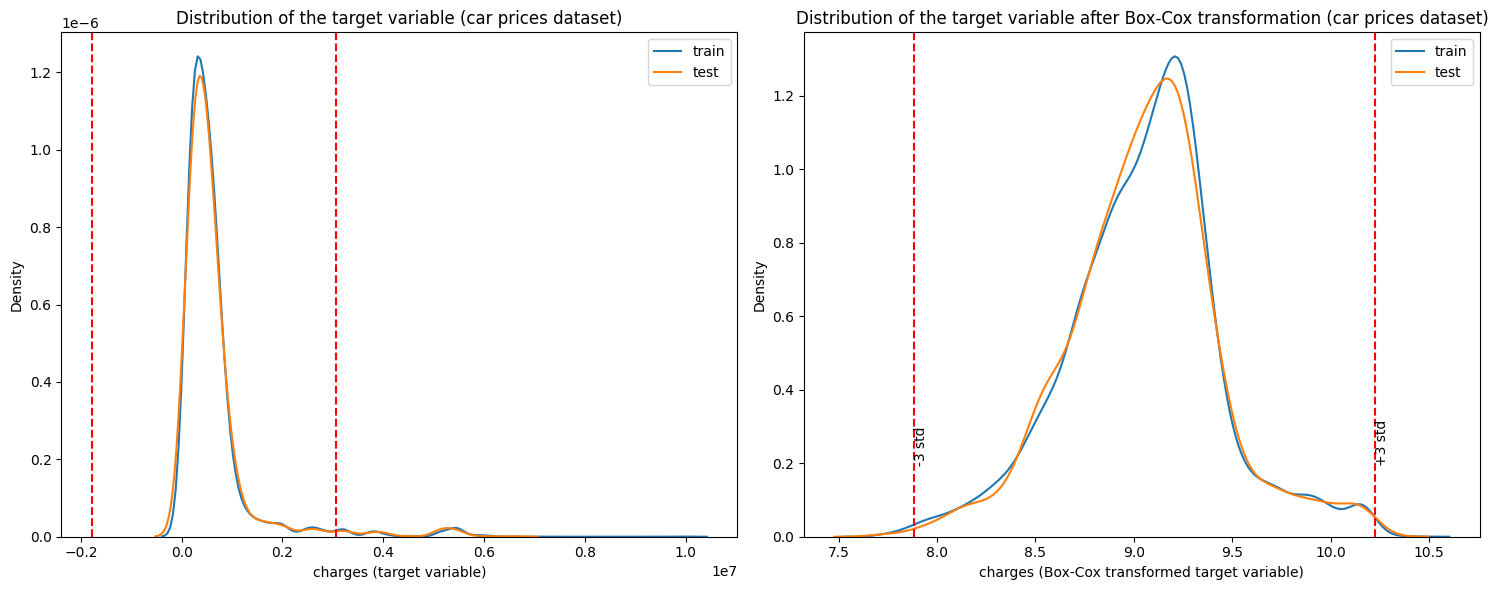

Number of values outside 3 standard deviations in the training set after performing box-cox transformation:  25
Number of values outside 3 standard deviations in the test set after performing box-cox transformation:  5


In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting a KDE plot of the target variable (without Box-Cox transformation):
sns.kdeplot(y_train, label="train", ax=axes[0])
sns.kdeplot(y_test, label="test", ax=axes[0])
axes[0].set_title("Distribution of the target variable (car prices dataset)")
axes[0].set_xlabel("charges (target variable)")
axes[0].axvline(y_train.mean() - 3*y_train.std(), color='red', linestyle='--')
axes[0].axvline(y_train.mean() + 3*y_train.std(), color='red', linestyle='--')
# Print how many values are outside 3 standard deviations (before performing Box-Cox transformation):
print("Number of values outside 3 standard deviations in the training set before performing box-cox transformation: ", len(y_train[(y_train < y_train.mean() - 3*y_train.std()) | (y_train > y_train.mean() + 3*y_train.std())]))
print("Number of values outside 3 standard deviations in the test set before performing box-cox transformation: ", len(y_test[(y_test < y_test.mean() - 3*y_test.std()) | (y_test > y_test.mean() + 3*y_test.std())]))
axes[0].legend()

# Plotting a KDE plot of the target variable (after peforming Box-Cox transformation):
y_train_bc, lambda_boxcox = boxcox(y_train)
y_test_bc = boxcox(y_test, lmbda=lambda_boxcox)
sns.kdeplot(y_train_bc, label="train", ax=axes[1])
sns.kdeplot(y_test_bc, label="test", ax=axes[1])
axes[1].set_xlabel("charges (Box-Cox transformed target variable)")

# Drawing red dotted lines at the mean and at +-3 standard deviations from the mean:
axes[1].axvline(y_train_bc.mean() - 3*y_train_bc.std(), color='red', linestyle='--')
axes[1].text(y_train_bc.mean() - 3*y_train_bc.std(), 0.2, "-3 std", rotation=90)
axes[1].axvline(y_train_bc.mean() + 3*y_train_bc.std(), color='red', linestyle='--')
axes[1].text(y_train_bc.mean() + 3*y_train_bc.std(), 0.2, "+3 std", rotation=90)

# Showing the plot:
axes[1].legend()
axes[1].set_title("Distribution of the target variable after Box-Cox transformation (car prices dataset)")
plt.tight_layout()
# The following line was used in order to save the plot as a PDF file (to be added as a figure in the article):
# plt.savefig('boxcoxBeforeAndAfterCarPrices.pdf', bbox_inches='tight')
plt.show()

# Print how many values are outside 3 standard deviations (now, after performing Box-Cox transformation):
print("Number of values outside 3 standard deviations in the training set after performing box-cox transformation: ", len(y_train_bc[(y_train_bc < y_train_bc.mean() - 3*y_train_bc.std()) | (y_train_bc > y_train_bc.mean() + 3*y_train_bc.std())]))
print("Number of values outside 3 standard deviations in the test set after performing box-cox transformation: ", len(y_test_bc[(y_test_bc < y_test_bc.mean() - 3*y_test_bc.std()) | (y_test_bc > y_test_bc.mean() + 3*y_test_bc.std())]))


As can be observed, as our adaptive algorithm recognized earlier, the original data is indeed heavily skewed; <b>when using the common "naive" Z-Score outlier detection method on the original data, we can see that <u>181 outliers are detected and removed from the training set</u></b>; however, after applying the box-cox transformation, we can see that the distribution becomes much more approximately normal distributed, thus <u>when using the Z-Score outlier detection method on the data after box-cox transformation, <i>only 25 outliers</i> are detected and removed from the training set!</u>
<br><br>
In other words, our Box-Cox + Z-Score sub-algorithm <u>removes ~85% less data points</u> compared to using Z-Score outlier detection on the original data; <b>and as we will see below, this more precise and 'less agressive' outlier removal will result in better model performance</b>.

<b>Now, to present the absolute numbers I will present a table</b> with the performance of the model after according to the original pipeline OR after applying each of the 2 baseline algorithms OR after applying each of the 3 sub-algorithms introduced in this project; this table is presented above, <b>and afterwards I will show plots presenting that information clearly, but in graphic display</b>.

In [47]:
# I create a list storing the results of each evaluation metric (R^2, MAPE, MAE, RMSE) for each of the 6 outlier removal methods:
results = []
# Iterating through all the six algorithms (the original pipeline, the two baseline algorithms, and the three sub-algorithms):
for method_name, method in methods.items():
    modified_train, modified_test = method(dtf_train.copy(), dtf_test.copy(), targetVariableName)
    metrics = train_and_evaluate(modified_train, modified_test, method_name, targetVariableName)
    # Saving the results for the current algorithm:
    results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df)

                           Method  R^2 Score      MAPE            MAE  \
0  Original - no outlier handling   0.920596  0.177840   83618.747797   
1                       Naive IQR   0.351563  0.195723  197731.974081   
2                   Naive Z-Score   0.767232  0.176215  125553.640667   
3               Box-Cox + Z-Score   0.951723  0.171966   77376.092592   
4         Adaptive IQR Multiplier   0.726026  0.174558  129340.276324   
5            Capping with Z-Score   0.935988  0.172544   80722.356189   

            RMSE  
0  228140.236422  
1  651951.359333  
2  390609.400981  
3  177890.756934  
4  423775.638488  
5  204838.996859  


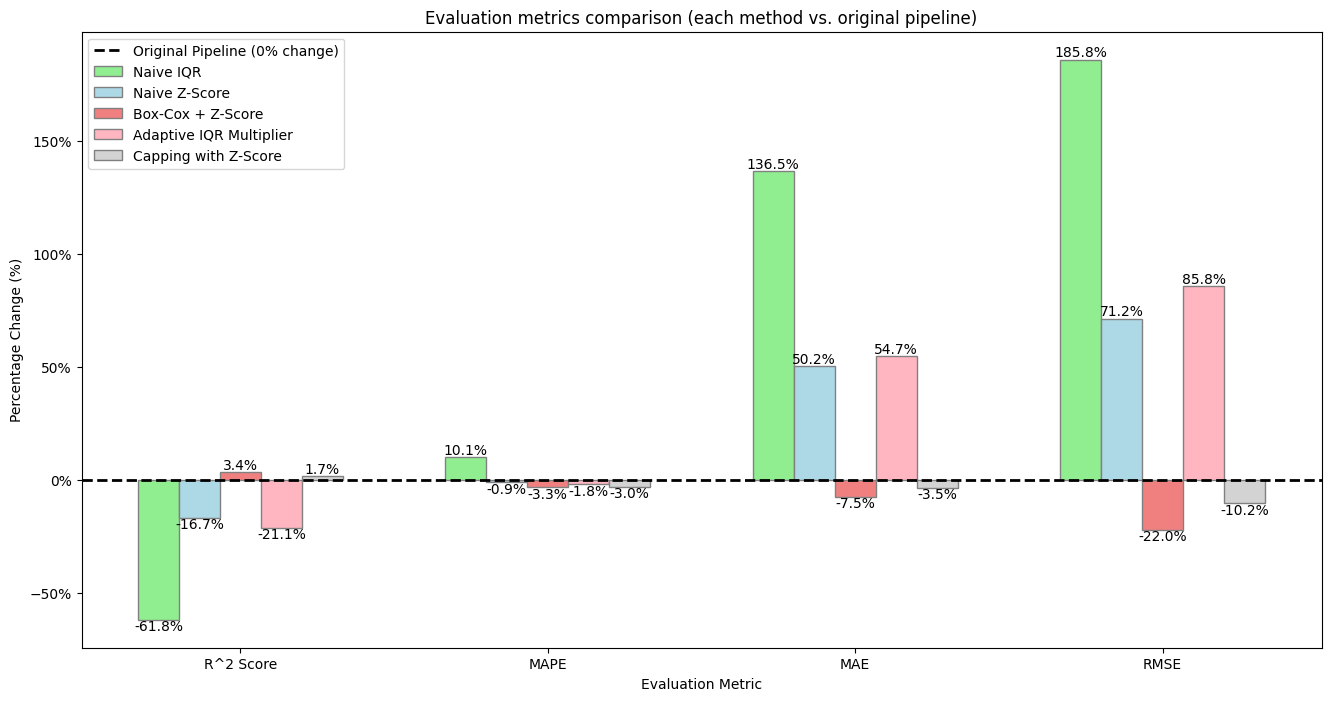

In [48]:
# Defining the evaluation metrics and their values for the original pipeline:
evaluation_metrics = ["R^2 Score", "MAPE", "MAE", "RMSE"]
original_values = results_df.loc[results_df["Method"] == "Original - no outlier handling", evaluation_metrics].values.flatten()

# Extracting the values for the evaluation metrics, for each algorithm (excluding the original pipeline, which will be used as the baseline, in a dotted line):
steps_values = [results_df.loc[results_df["Method"] == method, evaluation_metrics].values.flatten() for method in results_df["Method"] if method != "Original - no outlier handling"]

# Defining the labels for each algorithm and colors for the bars:
step_labels = [method for method in results_df["Method"] if method != "Original - no outlier handling"]
colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightpink', 'lightgrey', 'lightyellow']

# Ploting the evaluation metrics comparison:
plot_evaluation_metrics_comparison(evaluation_metrics, original_values, *steps_values, step_labels=step_labels, colors=colors)

Indeed, we can observe in the plot presented above that this sub-algorithm outperforms all the other algorithms including its most relevant baseline algorithm (the "naive Z-score", which performed poorly, leading to more than 50% higher MAE score, more than 70% higher RMSE score, and also leading to a $R^2$ score decreased by more than 16%); <u>this means that <i>de-skewing</i> by performing <i>Box-Cox</i> transformation, before using the Z-Score method, was indeed crucial</u>.
As can be observed above, <b>the selected sub-algorithm which our adaptive algorithm has selected (Box-Cox + Z-Score) has improved model's performance <u>by all four evaluation metrics</u></b>: the $R^2$ score is improved (increased) by 3.4%, the MAPE score is improved (decreased) by -3.3%, the MAE score is improved (decreased) by -7.5% and the RMSE score is improved (decreased) by -22.0%.

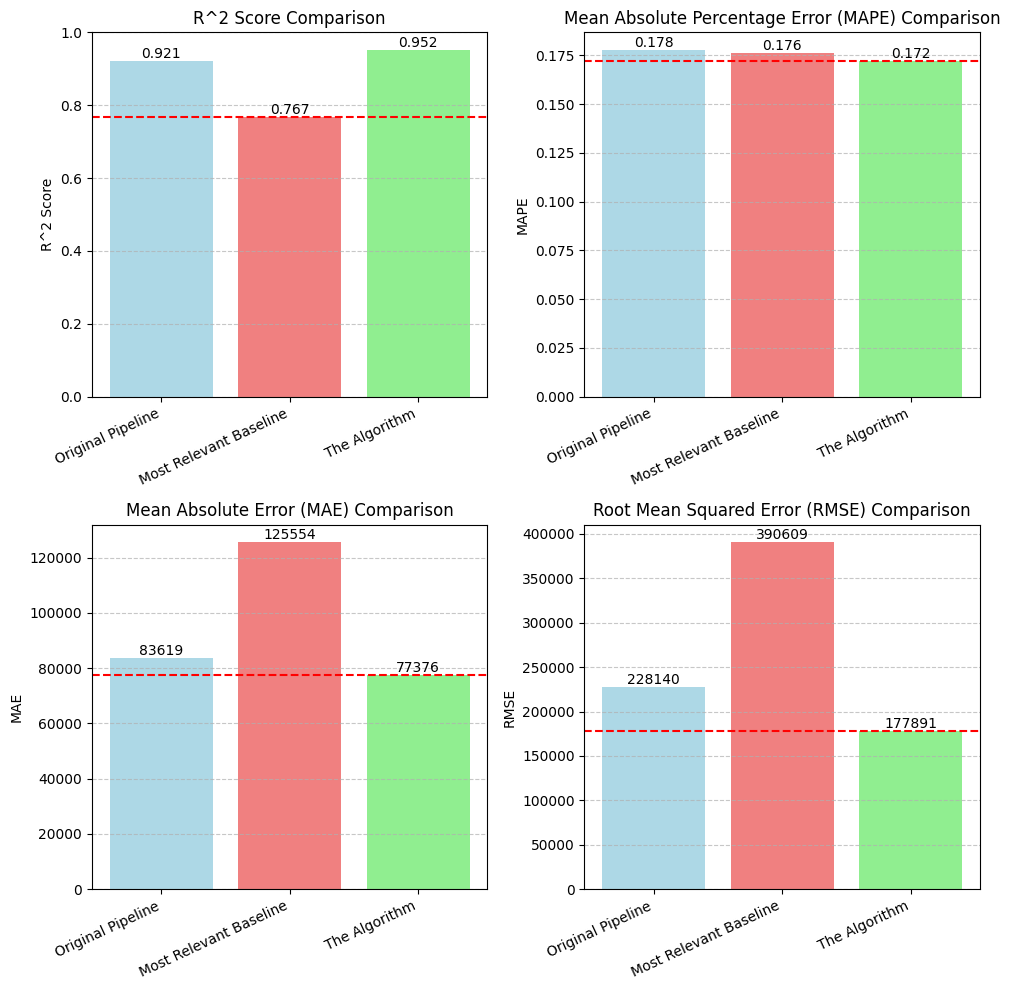

In [49]:
# Extracting the values from the results_df
xgb_r2_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "R^2 Score"].values[0]
xgb_mape_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "MAPE"].values[0]
xgb_mae_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "MAE"].values[0]
xgb_rmse_originalPipeline = results_df.loc[results_df["Method"] == "Original - no outlier handling", "RMSE"].values[0]

xgb_r2_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "R^2 Score"].values[0]
xgb_mape_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "MAPE"].values[0]
xgb_mae_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "MAE"].values[0]
xgb_rmse_mostRelevantBaseline = results_df.loc[results_df["Method"] == "Naive Z-Score", "RMSE"].values[0]

xgb_r2_bestMethod = results_df.loc[results_df["Method"] == "Box-Cox + Z-Score", "R^2 Score"].values[0]
xgb_mape_bestMethod = results_df.loc[results_df["Method"] == "Box-Cox + Z-Score", "MAPE"].values[0]
xgb_mae_bestMethod = results_df.loc[results_df["Method"] == "Box-Cox + Z-Score", "MAE"].values[0]
xgb_rmse_bestMethod = results_df.loc[results_df["Method"] == "Box-Cox + Z-Score", "RMSE"].values[0]

# Calling the function to plot the comparison - plotting a graph comparing each of the 4 evaluation metrics for the original pipeline and the improved pipeline:
plot_comparison(xgb_r2_originalPipeline, xgb_mape_originalPipeline, xgb_mae_originalPipeline, xgb_rmse_originalPipeline,
                xgb_r2_mostRelevantBaseline, xgb_mape_mostRelevantBaseline, xgb_mae_mostRelevantBaseline, xgb_rmse_mostRelevantBaseline,
                xgb_r2_bestMethod, xgb_mape_bestMethod, xgb_mae_bestMethod, xgb_rmse_bestMethod)


The plot above also shows that <b>The proposed algorithm not only outperforms the original pipeline performance, but also significantly outperforms the baseline outlier-handling algorithm;</b> In fact, the baseline algorithm (naive Z-Score outlier handling) <u>worsens the model's performance, by almost all four evaluation metrics</u>! (except from the MAPE score which has decreased from 0.178 to 0.176 - almost stays the same); this means that doing nothing is better than using naive Z-Score outlier-removal. The selected sub-algorithm, performing <i>Box-Cox transformation</i> before applying the Z-Score method for outlier detection, yields a performance improvement (contrary to the baseline Z-Score algorithm).
In other words, the problem was not the use of Z-Score, but using it with data which is heavily skewed, and not approximately normal distributed (as already explained earlier, this is a prequisite of the Z-Score method).

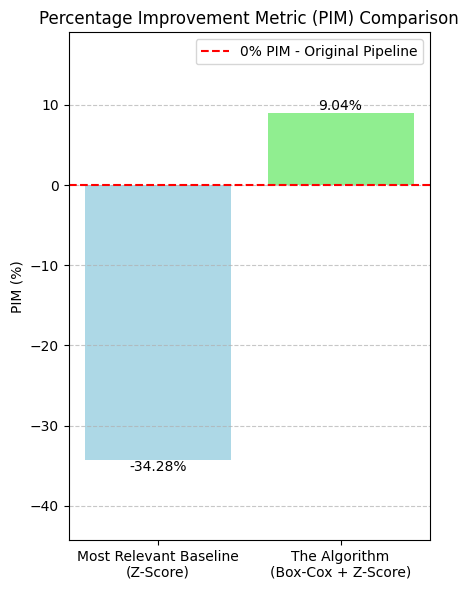

In [50]:
# Calling the function calculating the PIM score (Percentage Improvement Metric), getting the PIM scores both for the algorithm and for the most relevant baseline:
algorithm_PIM_score_carsDataset, most_relevant_baseline_PIM_score_carsDataset = calculatePIM(
    xgb_r2_originalPipeline, xgb_mape_originalPipeline, xgb_mae_originalPipeline, xgb_rmse_originalPipeline,
    xgb_r2_bestMethod, xgb_mape_bestMethod, xgb_mae_bestMethod, xgb_rmse_bestMethod,
    xgb_r2_mostRelevantBaseline, xgb_mape_mostRelevantBaseline, xgb_mae_mostRelevantBaseline, xgb_rmse_mostRelevantBaseline
)

# Call the function with the appropriate values
plot_pim_comparison(most_relevant_baseline_PIM_score_carsDataset, algorithm_PIM_score_carsDataset, "Z-Score", "Box-Cox + Z-Score")


<b>This plot shows a comparison between the PIM score of the our adaptive algorithm (which chose to perform the Box-Cox + Z-Score sub-algorithm) and the PIM score of the most relevant baseline algorithm</b> (naive Z-Score); we can see that our algorithm dramatically outperforms the baseline algorithm! In fact, while the baseline algorithm only degarded the model's performance compared to the original pipeline (by more than 34%!), our algorithm not only achieved better performance compared to the original pipeline (improved the PIM score by more than 9% compared to the original pipeline, which is relatively an excellent improvement), <b>but also compared to the popular and commonly used naive Z-Score method for detecting outliers. <u>This indicates that applying Box-Cox transformation as a preliminary step,  before using the Z-Score method for outlier detection, indeed succeeds in addressing the issue of data with distribution which is not close to the normal distribution, which yields better model performance</u>.</b>

----

### <b>Now, I will summarize the four plots showing the PIM scores comparison <u>for all four datasets</u> (the algorithm performance vs. the most relevant baseline performance):</b>

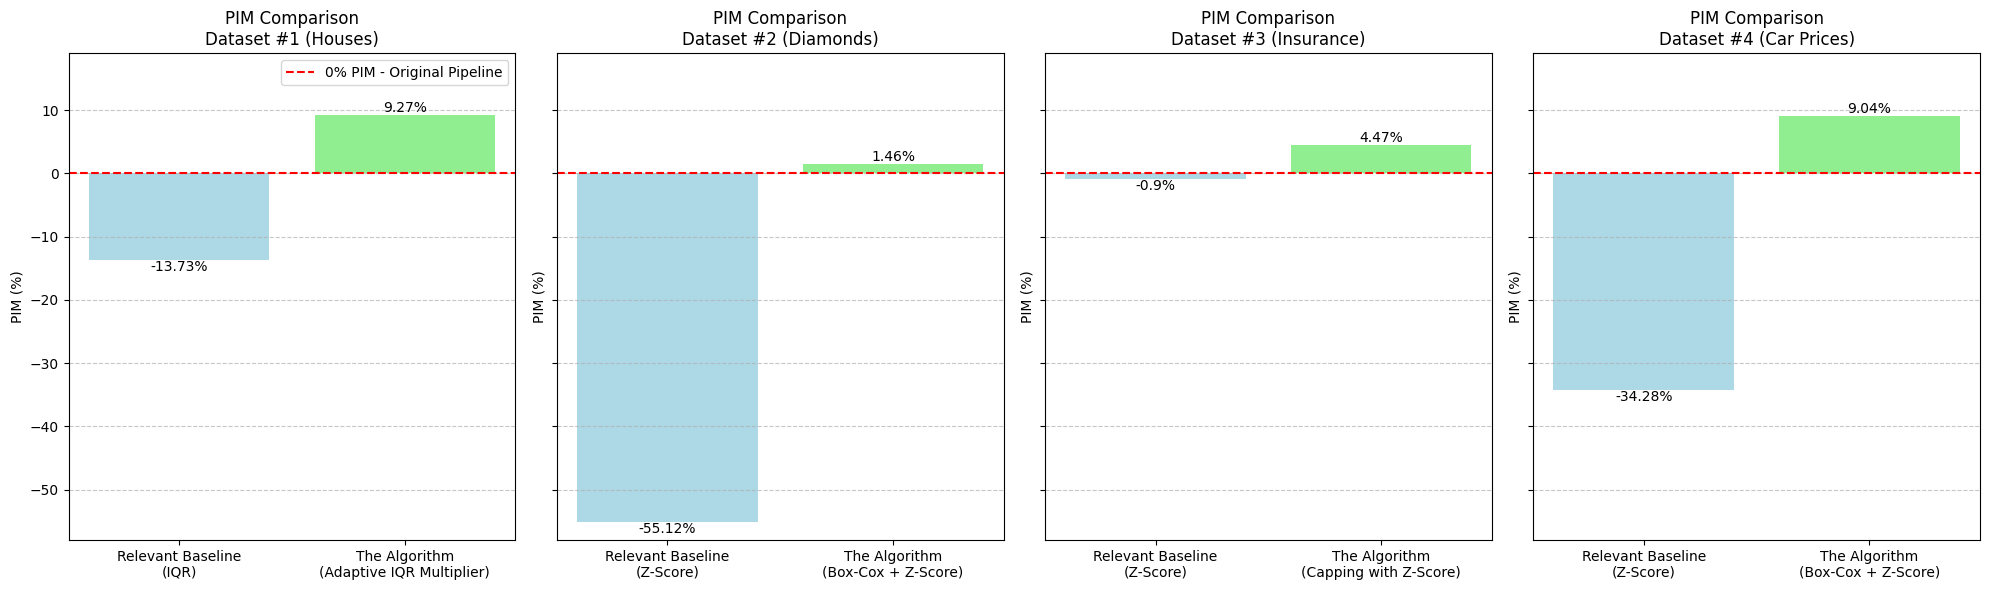

In [51]:
# Presenting the four plots, one for each dataset, comparing the PIM values between the algorithm and the most relevant baseline:
plot_pim_comparison_forAllFourDatasets(most_relevant_baseline_PIM_score_housesDataset, algorithm_PIM_score_housesDataset, 'Dataset #1 (Houses)', "IQR", "Adaptive IQR Multiplier",
                                       most_relevant_baseline_PIM_score_diamondsDataset, algorithm_PIM_score_diamondsDataset, 'Dataset #2 (Diamonds)', "Z-Score", "Box-Cox + Z-Score",
                                       most_relevant_baseline_PIM_score_insuranceDataset, algorithm_PIM_score_insuranceDataset, 'Dataset #3 (Insurance)', "Z-Score", "Capping with Z-Score",
                                       most_relevant_baseline_PIM_score_carsDataset, algorithm_PIM_score_carsDataset, 'Dataset #4 (Car Prices)', "Z-Score", "Box-Cox + Z-Score")

As can be observed from the plots above, <b>the data-driven algorithm I have designed has an improved (positive) PIM while the most relevant baseline algorithm always achieved a lower PIM and even a negative PIM (worse results than doing nothing)</b>.
To summarize, I will show the relative PIM improvement (algorithm vs. the most relevant baseline) for all four datasets: 


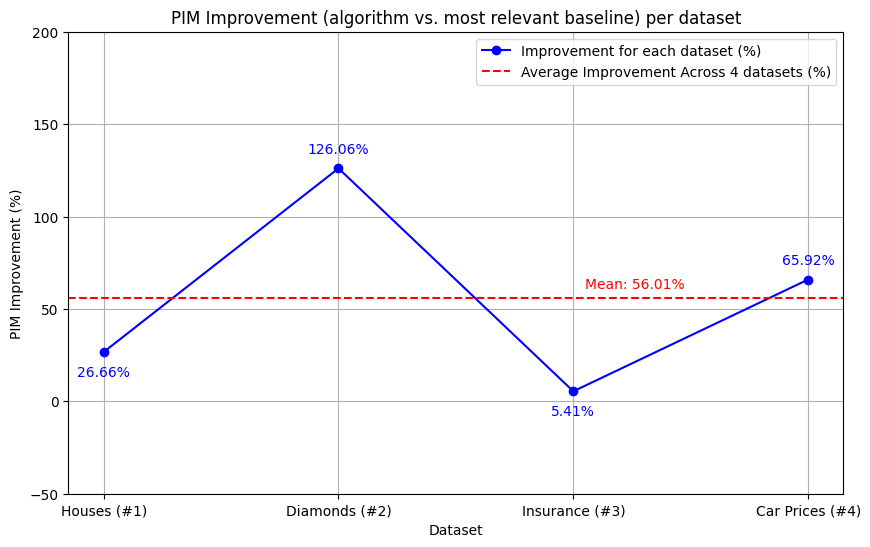

In [52]:
# The formula I use is: 100*((1+(algorithm_PIM_score_currDataset/100))/(1-((-1)*most_relevant_baseline_PIM_score_currDataset/100))-1):
# This formula gives us the percentage improvement in the PIM score of the algorithm over the most relevant baseline.
percentage_improvement_housesDataset = 100*(((1+(algorithm_PIM_score_housesDataset/100))/(1-((-1)*most_relevant_baseline_PIM_score_housesDataset/100)))-1)
percentage_improvement_diamondsDataset = 100*((1+(algorithm_PIM_score_diamondsDataset/100))/(1-((-1)*most_relevant_baseline_PIM_score_diamondsDataset/100))-1)
percentage_improvement_insuranceDataset = 100*((1+(algorithm_PIM_score_insuranceDataset/100))/(1-((-1)*most_relevant_baseline_PIM_score_insuranceDataset/100))-1)
percentage_improvement_carsDataset = 100*((1+(algorithm_PIM_score_carsDataset/100))/(1-((-1)*most_relevant_baseline_PIM_score_carsDataset/100))-1)

# Now, we create a plot, with 4 dots - one for each dataset, showing the percentage improvement in the PIM score of the algorithm over the most relevant baseline for each dataset:
# also, there will be a line showing the average percentage improvement over the 4 datasets.
plt.figure(figsize=(10, 6))
plt.plot(["Houses (#1)", "Diamonds (#2)", "Insurance (#3)", "Car Prices (#4)"], [percentage_improvement_housesDataset, percentage_improvement_diamondsDataset, percentage_improvement_insuranceDataset, percentage_improvement_carsDataset], 'bo-', label="Improvement for each dataset (%)")

# Drawing a dotted red line showing the average percentage PIM improvement over the 4 datasets:
plt.axhline(y=(percentage_improvement_housesDataset + percentage_improvement_diamondsDataset + percentage_improvement_insuranceDataset + percentage_improvement_carsDataset)/4, color='r', linestyle='--', label="Average Improvement Across 4 datasets (%)")

# Now, for each dataset, I add a text label showing its value:
plt.text(0, percentage_improvement_housesDataset - 13, f"{percentage_improvement_housesDataset:.2f}%", color='blue', ha="center")
plt.text(1, percentage_improvement_diamondsDataset + 8, f"{percentage_improvement_diamondsDataset:.2f}%", color='blue', ha="center")
plt.text(2, percentage_improvement_insuranceDataset - 13, f"{percentage_improvement_insuranceDataset:.2f}%", color='blue', ha="center")
plt.text(3, percentage_improvement_carsDataset + 8, f"{percentage_improvement_carsDataset:.2f}%", color='blue', ha="center")

# Showing the plot:
plt.xlabel("Dataset")
plt.ylabel("PIM Improvement (%)")
plt.xticks(["Houses (#1)", "Diamonds (#2)", "Insurance (#3)", "Car Prices (#4)"])
ylabels = [-50, 0, 50, 100, 150, 200]
plt.yticks(ylabels)
# Showing text with the average percentage improvement over the 4 datasets: (with the value the dotted red line represents)
plt.text(2.05, (percentage_improvement_housesDataset + percentage_improvement_diamondsDataset + percentage_improvement_insuranceDataset + percentage_improvement_carsDataset)/4 + 5, f"Mean: {(percentage_improvement_housesDataset + percentage_improvement_diamondsDataset + percentage_improvement_insuranceDataset + percentage_improvement_carsDataset)/4:.2f}%", color='red')
plt.ylim(-50, 200)
plt.title("PIM Improvement (algorithm vs. most relevant baseline) per dataset")
plt.legend()
plt.grid()
# The following line was used in order to save the plot as a PDF file (to be added as a figure in the article):
# plt.savefig('percentageImprovementForAllDatasets.pdf', bbox_inches='tight')
plt.show()


<b>The plot above shows the relative PIM improvement</b> (higher PIM than baseline), ranging up to 126% (for the Diamond dataset), <u>consistently positive</u> (always better than the baseline) and its <i>mean</i> improvement is about 56%. 
The conclusion is that according to each specific dataset, we can choose the right approach to deal with outliers; however, if we do not tune each approach and optimize it (e.g. using the generic and popular 1.5 IQR multiplier) we may end up with worse results than doing nothing. <b>This emphasizes the importance of making use of the techniques that were developed here.</b>


Before ending, I will once more note that this notebook accompanies the full article I wrote about this project (<b>"Automated Adaptive Outlier Handling"</b>), following is a link to the article:
> **Reference**: [<b>link to the full article (LATEX-generated PDF file)</b>](https://github.com/YoavYoscov/TabularDataScience/blob/main/FinalResearchProject/Automated%20Adaptive%20Outlier%20Handling.pdf).
